<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_with_tensorflow_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

The goal of this notebook is to get familiar working with Time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [2]:
# check for gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-98bcf130-3f10-c896-7602-bdea527755c5)


## Get the data

To build a time series forecasting model, the first thing we're going to need is data.

So we're going to get the data of Bitcoin from some source like [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1679356800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) in csv format.

I've downloaded it in csv format and currently in the [github repo](https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv).

Let's download it into the colab and view what it looks like.

In [3]:
!wget https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv

--2023-04-21 03:34:15--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255951 (250K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 249.95K  --.-KB/s    in 0.003s  

2023-04-21 03:34:15 (78.2 MB/s) - ‘BTC-USD.csv’ saved [255951/255951]



### Importing time series data with pandas

In [4]:
## read with pandas
import pandas as pd

df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27964.888672,27964.888672,41356222464


So we have daily prices of Bitcoin from **17th Sept 2014** to **21st March 2023**, almost 8+ years

In [6]:
len(df)

3108

In [7]:
3108/365

8.515068493150684

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2014-09-17 to 2023-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3108 non-null   float64
 1   High       3108 non-null   float64
 2   Low        3108 non-null   float64
 3   Close      3108 non-null   float64
 4   Adj Close  3108 non-null   float64
 5   Volume     3108 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 170.0 KB


Different types of Time Series Data

- **Trend**: time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal**: time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
- **Cyclic**: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

For more insights on various kinds of Time series data, please read [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html)

To simplify let's remove some of the columns from our data so we're only left with a date index and the closing price

In [9]:
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


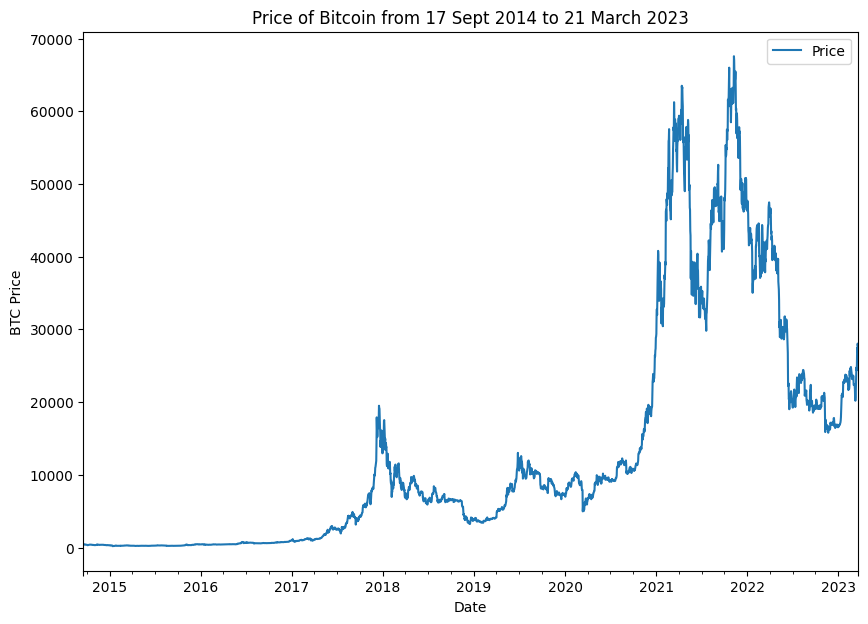

In [10]:
# let's plot everything
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

### Importing time series data with Python's CSV module

In [11]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[5])) # get the adjusted closing price

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Let's plot this

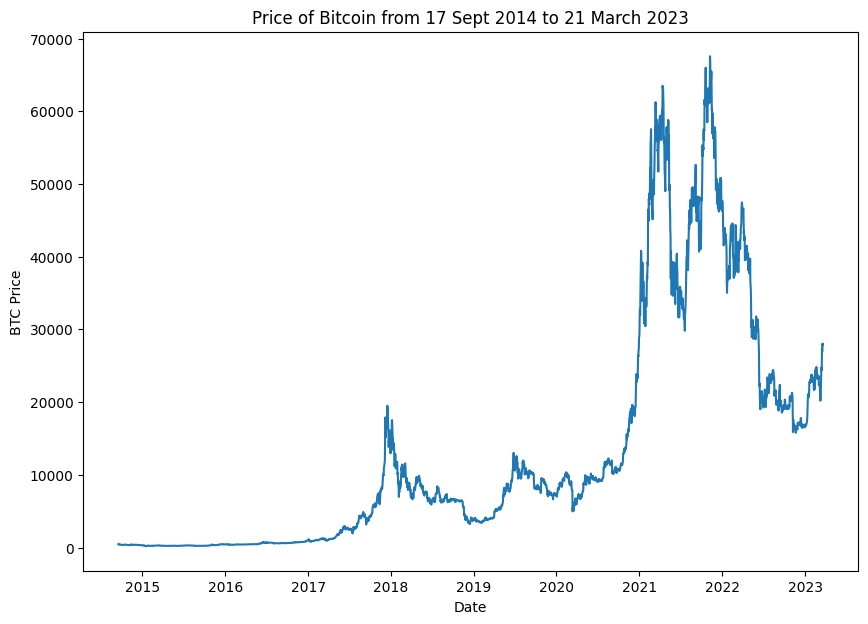

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

## Format Data Part 1 : Create train and test sets for Time Series data

Before we create splits we want to know what kind of data we have.

In time series problems, you'll either have **univariate** and **multivariate** data.

- Univariate time series data deals with one variable, for example using the price of bitcoin to predict the price of bitcoin
- Multivariate time series data deals with more than one variable, for example predicting the price of bitcoin using the price of bitcoin and block rewards and volume

### Create Train and Test sets for time series (wrong way)


In [13]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2486,), (622,), (2486,), (622,))

Looks like the splits worked well, but let's not trust numbers on a page, visualize, visualize and visualize

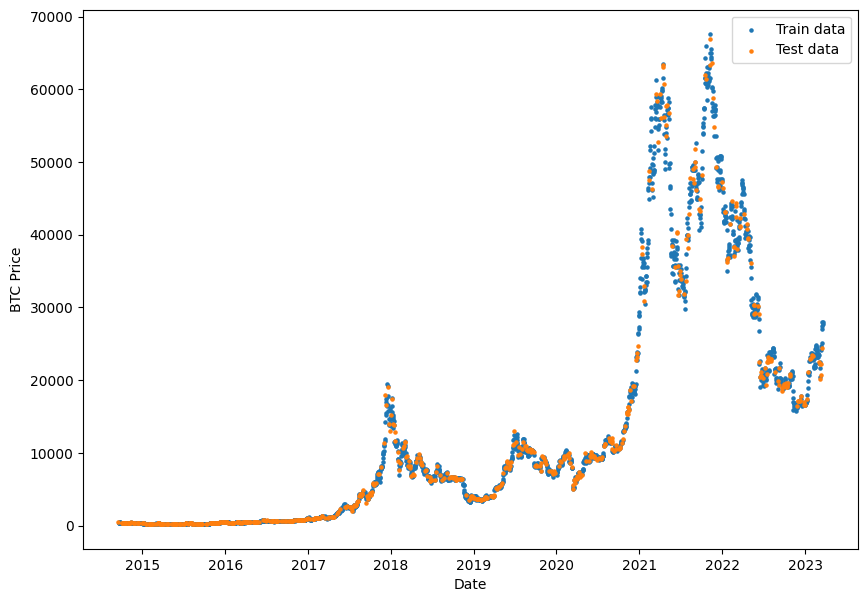

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend();

Since this is a time component so the split should be continous, if there is no time component then random split will work but since we are going to forecast the future, then we need past data.

### Create Train and Test sets for time series (the right way)

In [15]:
split_size = int(0.8 * len(prices)) # 80% of train sets and 20% of test sets

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]



Now if we visualize the plot,

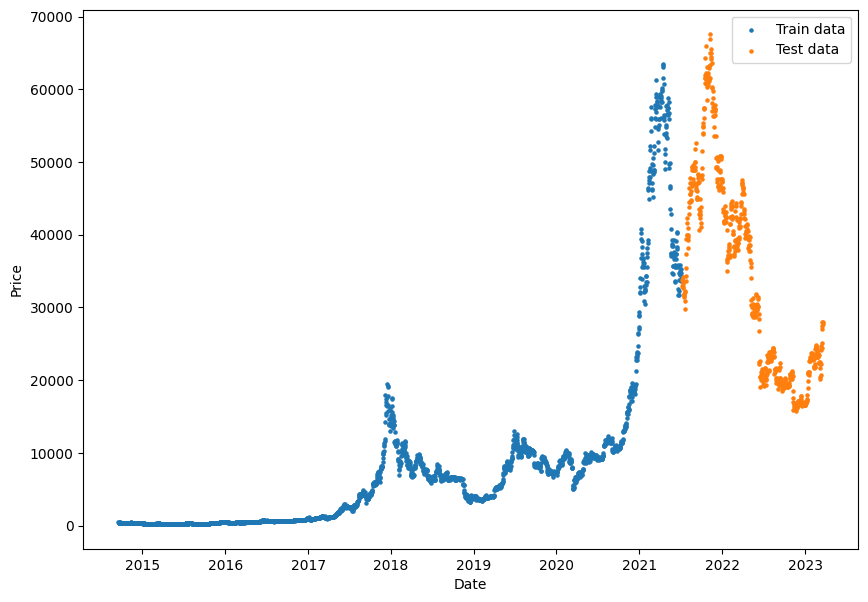

In [16]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

This is the correct way of splitting the data of time series problem. The plot should look like above.

### Creating a plotting function

Rather than retyping `matplotlib` commands to continously plot data, let's make a plotting function we can reuse later

In [17]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a time series plot on timesteps (a series of points in time) against values
  (a series of values across timesteps)

  Parameters
  ------------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

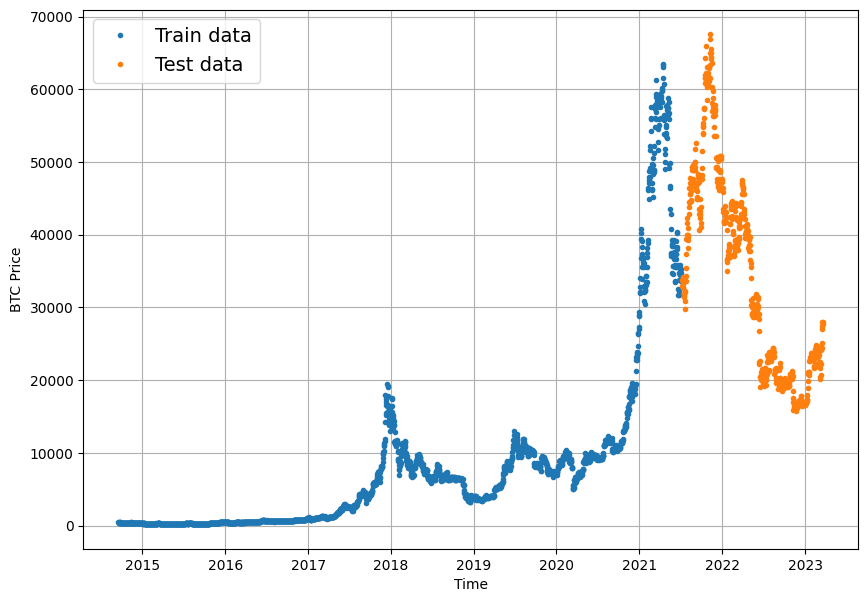

In [18]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling Experiments

There are two terms that we should be familiar with, **horizon** and **window**,
- **horizon**: number of timesteps to predict into future
- **window**: number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for Tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and window would be 7.


List of modelling experiments we are going to perform,


| **Model Number** | **Model Type** | **Horizon Size** | **Window Size** | **Extra data** |
|-------------|--------------|------------|------------|------------|
| 0 | Naive forecast (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | same as 1 (but with univariate) | 1 | 7 | Block reward size/Volume |
| 7 | [N-Beats Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0 : Naive forecast (baseline)

One of the most common baseline models for time series forecasting is naive model, (also called the naive forecast), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t`(y-hat) is equal to the value at timestep `t-1`(the previous timestep)

In an open system (like a stock market or crypto market), you'll often find beating the naive forecast with any kind of model is quite hard.

> 🔑 **Note**: an **open system** is a system where inputs and outputs can freely flow, such as market (stock or crypto), whereas a **closed system** the inputs and outputs are contained within the system (like a poker game with friends, as we know the buy in and how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [19]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:] # view first and last 10

(array([32877.371094, 33798.011719, 33520.519531, 34240.1875  ,
        33155.847656, 32702.025391, 32822.347656, 31780.730469,
        31421.539063, 31533.068359]),
 array([20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938, 25052.789063, 27423.929688, 26965.878906,
        28038.675781, 27767.236328]))

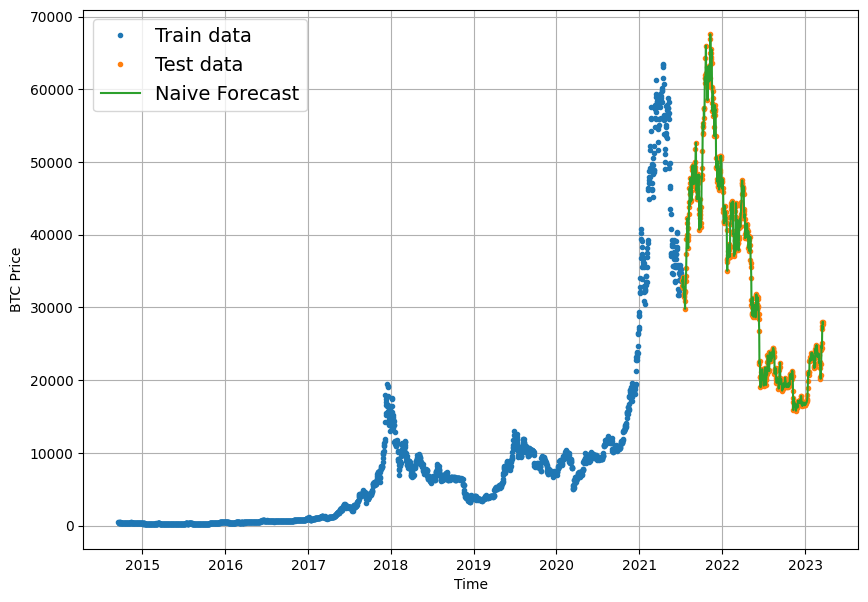

In [20]:
# plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast");

Let's zoom it and only plot the test and naive forecast


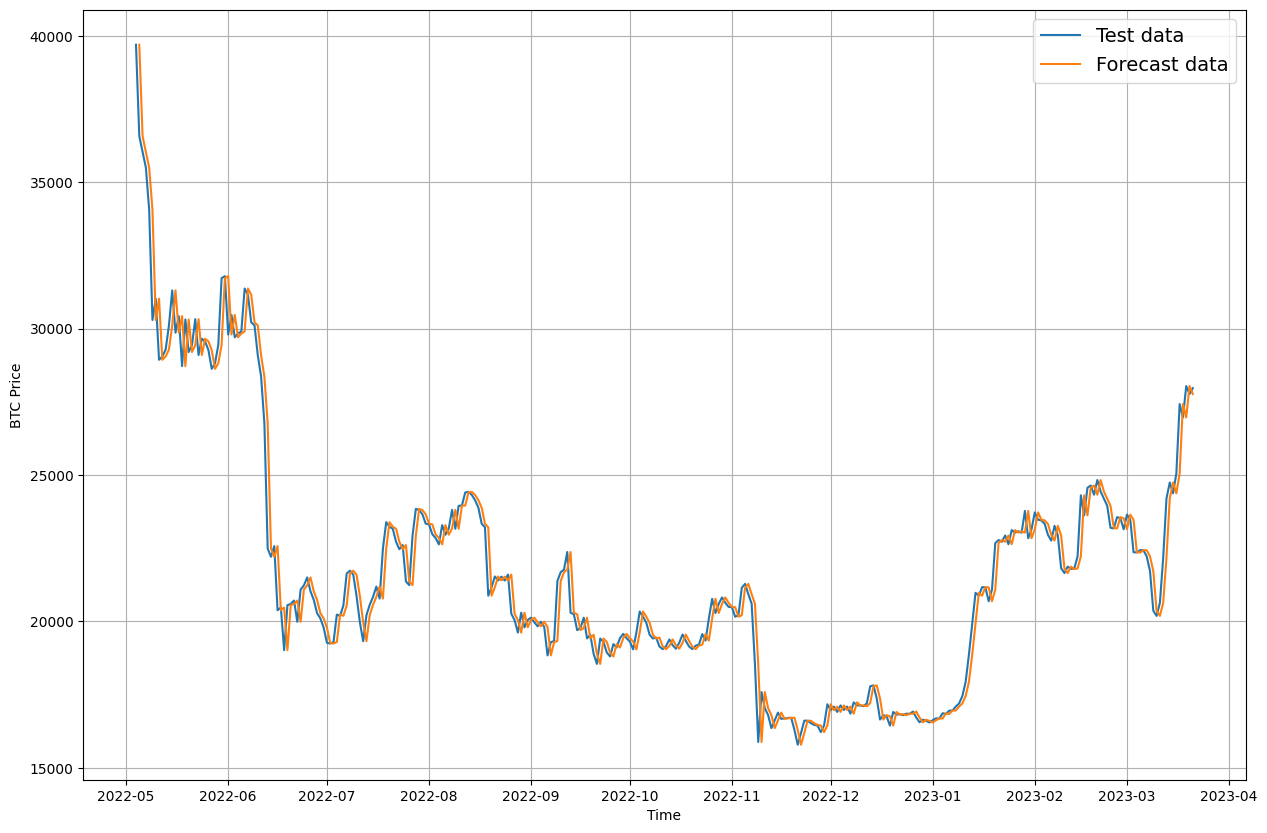

In [21]:
plt.figure(figsize=(15,10))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format="-", label="Forecast data");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a Time series model

Time series problem is often involves predicting a number which is the same output as Regression model, so we can similar types of metrics to evaluate Time series model, but let's see what are they, but thing to note for all the metrics, **lower the better** (for example an MAE of 0 is better than MAE 100).

### Scale Dependent Errors

These are metrics which can be used to compare time series values and forecasts which are in same scale.

for example, predicting the price of Bitcoin using historical prices in USD versus forecasting values in USD

| Metric | Details | Code |
| ------ |------ |------ |
| MAE (mean absolute error) |Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean squared error) | Forecasts which minimises the RMSE lead to forecasts of the mean | `tf.sqrt(tf.keras.metrics.mean_square_error())` |

### Percentage Errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used precentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| sMAPE (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions | Custom implementation |


### Scaled Errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MASE (mean absolute scaled error) | MASE equals one of the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE | See sktime's, [`mase_loss`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Creating our own MASE function

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime)(Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.
                                                                                                                          
                                                                                                                                                                                                                                                    


In [22]:
import tensorflow as tf

In [23]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

Let's put each of our different evaluation metrics together into a function.

In [24]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [25]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

Alright, this will be our baseline results to beat in further modelling experiment.

So if we look into `mae` result, it's `807.27` it means that each prediction in the naive forecast is off by **$807**

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name |	Resource |
| ---- | ---- |
| Moving average |	https://machinelearningmastery.com/ moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) |	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) |	https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) |	https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) |	https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) |	https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window ?

Windowing is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example, for a univariate time series, windowing for one week (window=7) to predict the next single value(horizon=1) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Similarly the price of Bitcoin look like,

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, these are just randomly picked)

In [26]:
HORIZON = 1
WINDOW_SIZE = 7

In [27]:
# Create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset

  E.g if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we can do the same thing with entire time series data through Python loops, but to make things faster we can use [Numpy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).


Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses Numpy indexing to create a 2D of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
```
3. Uses the 2D array of multiple window steps to index on a target series.
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.




In [29]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"window_step: \n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  #print(f"Window indexes: \n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Let's try with bitcoin prices

In [30]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3101, 3101)

In [31]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987] 
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005] 
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988] 


In [32]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [22163.949219 24197.533203 24746.074219 24375.960938 25052.789063
 27423.929688 26965.878906] -> Label: [28038.675781] 
Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328] 
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [27964.888672] 


Anyways, we have written the whole function but this can also be achieved using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

### Turning windows into Training and Test sets



In [33]:
# Make the train and test split
def make_train_test_split(windows, labels, test_split=0.2):

  split_size=int(len(windows) * (1-test_split)) # this will be default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [34]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2480, 621, 2480, 621)

In [35]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

## Creating a Model Checkpoint

For a fair comparison between all the models that we're going to build, we need to train it with equal amount of epochs let's say 100 and then store the best performing model during training so that we can compare with the best performing model.

This can be possible using `ModelCheckpoint`.

`ModelCheckpoint` callback will monitor our model's performance during training and save the best model to the file by setting `save_best_only=True`


In [36]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

We're going to start by keeping it simple, `model_1` will have:
- A single dense layer with 128 hidden units and reLu activation
- An output layer with linear activation
- Adam optimizer and MAE, MSE metrics
- Batch size of 128

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')


# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 4936.7090 - mae: 4936.7090  

20/20 [==============================] - 8s 42ms/step - loss: 4936.7090 - mae: 4936.7090 - val_loss: 2146.0740 - val_mae: 2146.0740
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 975.9554 - mae: 975.9554 - val_loss: 2881.0537 - val_mae: 2881.0537
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 850.8004 - mae: 850.8004

20/20 [==============================] - 1s 26ms/step - loss: 535.1130 - mae: 535.1130 - val_loss: 1564.0302 - val_mae: 1564.0302
Epoch 4/100
17/20 [========================>.....] - ETA: 0s - loss: 454.5752 - mae: 454.5752

20/20 [==============================] - 1s 27ms/step - loss: 437.1320 - mae: 437.1320 - val_loss: 1327.2537 - val_mae: 1327.2537
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 428.8854 - mae: 428.8854

20/20 [==============================] - 1s 27ms/step - loss: 400.9366 - mae: 400.9366 - val_loss: 1268.7285 - val_mae: 1268.7285
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 390.7402 - mae: 390.7402 - val_loss: 1305.2423 - val_mae: 1305.2423
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 378.8447 - mae: 378.8447

20/20 [==============================] - 1s 27ms/step - loss: 378.8447 - mae: 378.8447 - val_loss: 1171.6200 - val_mae: 1171.6200
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 384.8996 - mae: 384.8996

20/20 [==============================] - 1s 28ms/step - loss: 386.3889 - mae: 386.3889 - val_loss: 1134.3125 - val_mae: 1134.3125
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 357.4756 - mae: 357.4756 - val_loss: 1203.7723 - val_mae: 1203.7723
Epoch 10/100
15/20 [=====================>........] - ETA: 0s - loss: 344.9059 - mae: 344.9059

20/20 [==============================] - 1s 38ms/step - loss: 341.4319 - mae: 341.4319 - val_loss: 1082.0277 - val_mae: 1082.0277
Epoch 11/100
20/20 [==============================] - 0s 4ms/step - loss: 330.1477 - mae: 330.1477 - val_loss: 1167.5055 - val_mae: 1167.5055
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 344.7254 - mae: 344.7254

20/20 [==============================] - 1s 26ms/step - loss: 344.7254 - mae: 344.7254 - val_loss: 1081.3531 - val_mae: 1081.3531
Epoch 13/100
 1/20 [>.............................] - ETA: 0s - loss: 358.5413 - mae: 358.5413

20/20 [==============================] - 1s 31ms/step - loss: 322.9641 - mae: 322.9641 - val_loss: 1022.6385 - val_mae: 1022.6385
Epoch 14/100
20/20 [==============================] - 0s 7ms/step - loss: 313.2609 - mae: 313.2609 - val_loss: 1041.9143 - val_mae: 1041.9143
Epoch 15/100
14/20 [====================>.........] - ETA: 0s - loss: 313.0121 - mae: 313.0121

20/20 [==============================] - 1s 38ms/step - loss: 309.9004 - mae: 309.9004 - val_loss: 1015.2325 - val_mae: 1015.2325
Epoch 16/100
14/20 [====================>.........] - ETA: 0s - loss: 307.2173 - mae: 307.2173

20/20 [==============================] - 1s 38ms/step - loss: 305.9748 - mae: 305.9748 - val_loss: 982.3464 - val_mae: 982.3464
Epoch 17/100
20/20 [==============================] - 0s 6ms/step - loss: 301.6611 - mae: 301.6611 - val_loss: 1008.1576 - val_mae: 1008.1576
Epoch 18/100
20/20 [==============================] - 0s 6ms/step - loss: 298.5183 - mae: 298.5183 - val_loss: 1026.5708 - val_mae: 1026.5708
Epoch 19/100
20/20 [==============================] - 0s 6ms/step - loss: 302.7028 - mae: 302.7028 - val_loss: 1349.8076 - val_mae: 1349.8076
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 341.3384 - mae: 341.3384 - val_loss: 1370.9941 - val_mae: 1370.9941
Epoch 21/100
 1/20 [>.............................] - ETA: 0s - loss: 372.1489 - mae: 372.1489

20/20 [==============================] - 0s 25ms/step - loss: 304.7593 - mae: 304.7593 - val_loss: 975.6441 - val_mae: 975.6441
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 305.0052 - mae: 305.0052 - val_loss: 1092.3527 - val_mae: 1092.3527
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 296.2289 - mae: 296.2289 - val_loss: 1169.9474 - val_mae: 1169.9474
Epoch 24/100
20/20 [==============================] - 0s 5ms/step - loss: 308.1055 - mae: 308.1055 - val_loss: 1093.0034 - val_mae: 1093.0034
Epoch 25/100
17/20 [========================>.....] - ETA: 0s - loss: 291.5592 - mae: 291.5592

20/20 [==============================] - 1s 27ms/step - loss: 284.6089 - mae: 284.6089 - val_loss: 940.5982 - val_mae: 940.5982
Epoch 26/100
20/20 [==============================] - 0s 4ms/step - loss: 278.2507 - mae: 278.2507 - val_loss: 995.1920 - val_mae: 995.1920
Epoch 27/100
20/20 [==============================] - 0s 5ms/step - loss: 289.5721 - mae: 289.5721 - val_loss: 949.0721 - val_mae: 949.0721
Epoch 28/100
 1/20 [>.............................] - ETA: 0s - loss: 274.8541 - mae: 274.8541

20/20 [==============================] - 1s 28ms/step - loss: 282.7409 - mae: 282.7409 - val_loss: 914.0839 - val_mae: 914.0839
Epoch 29/100
20/20 [==============================] - 0s 5ms/step - loss: 275.3974 - mae: 275.3974 - val_loss: 941.5334 - val_mae: 941.5334
Epoch 30/100
 1/20 [>.............................] - ETA: 0s - loss: 218.0203 - mae: 218.0203

20/20 [==============================] - 1s 26ms/step - loss: 286.8356 - mae: 286.8356 - val_loss: 908.6709 - val_mae: 908.6709
Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 272.0030 - mae: 272.0030

20/20 [==============================] - 1s 27ms/step - loss: 272.0030 - mae: 272.0030 - val_loss: 903.9944 - val_mae: 903.9944
Epoch 32/100
20/20 [==============================] - 0s 5ms/step - loss: 271.8849 - mae: 271.8849 - val_loss: 1004.1627 - val_mae: 1004.1627
Epoch 33/100
20/20 [==============================] - 0s 4ms/step - loss: 315.4851 - mae: 315.4851 - val_loss: 1127.8362 - val_mae: 1127.8362
Epoch 34/100
14/20 [====================>.........] - ETA: 0s - loss: 279.3994 - mae: 279.3994

20/20 [==============================] - 1s 28ms/step - loss: 277.8404 - mae: 277.8404 - val_loss: 901.6354 - val_mae: 901.6354
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 272.8412 - mae: 272.8412

20/20 [==============================] - 1s 27ms/step - loss: 272.8412 - mae: 272.8412 - val_loss: 895.9127 - val_mae: 895.9127
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 270.3898 - mae: 270.3898 - val_loss: 968.8310 - val_mae: 968.8310
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 270.3741 - mae: 270.3741 - val_loss: 902.1487 - val_mae: 902.1487
Epoch 38/100
 1/20 [>.............................] - ETA: 0s - loss: 193.5701 - mae: 193.5701

20/20 [==============================] - 1s 27ms/step - loss: 269.5358 - mae: 269.5358 - val_loss: 889.5530 - val_mae: 889.5530
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 281.8699 - mae: 281.8699 - val_loss: 959.3364 - val_mae: 959.3364
Epoch 40/100
20/20 [==============================] - 0s 5ms/step - loss: 288.6734 - mae: 288.6734 - val_loss: 1140.9670 - val_mae: 1140.9670
Epoch 41/100
20/20 [==============================] - 0s 5ms/step - loss: 287.9312 - mae: 287.9312 - val_loss: 920.1353 - val_mae: 920.1353
Epoch 42/100
20/20 [==============================] - ETA: 0s - loss: 269.4801 - mae: 269.4801

20/20 [==============================] - 1s 26ms/step - loss: 269.4801 - mae: 269.4801 - val_loss: 875.9879 - val_mae: 875.9879
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 264.5846 - mae: 264.5846 - val_loss: 937.4828 - val_mae: 937.4828
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 269.7351 - mae: 269.7351 - val_loss: 881.2013 - val_mae: 881.2013
Epoch 45/100
20/20 [==============================] - 0s 5ms/step - loss: 279.5857 - mae: 279.5857 - val_loss: 942.5647 - val_mae: 942.5647
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 270.6500 - mae: 270.6500 - val_loss: 919.1000 - val_mae: 919.1000
Epoch 47/100
 1/20 [>.............................] - ETA: 0s - loss: 195.8405 - mae: 195.8405

20/20 [==============================] - 1s 40ms/step - loss: 266.9881 - mae: 266.9881 - val_loss: 862.0594 - val_mae: 862.0594
Epoch 48/100
 1/20 [>.............................] - ETA: 0s - loss: 254.2856 - mae: 254.2856

20/20 [==============================] - 1s 26ms/step - loss: 260.1468 - mae: 260.1468 - val_loss: 860.9119 - val_mae: 860.9119
Epoch 49/100
20/20 [==============================] - 0s 5ms/step - loss: 261.5104 - mae: 261.5104 - val_loss: 905.3967 - val_mae: 905.3967
Epoch 50/100
19/20 [===========================>..] - ETA: 0s - loss: 260.9254 - mae: 260.9254

20/20 [==============================] - 1s 27ms/step - loss: 260.6867 - mae: 260.6867 - val_loss: 859.1381 - val_mae: 859.1381
Epoch 51/100
20/20 [==============================] - ETA: 0s - loss: 263.9699 - mae: 263.9699

20/20 [==============================] - 1s 27ms/step - loss: 263.9699 - mae: 263.9699 - val_loss: 857.9141 - val_mae: 857.9141
Epoch 52/100
18/20 [==========================>...] - ETA: 0s - loss: 257.3351 - mae: 257.3351

20/20 [==============================] - 1s 27ms/step - loss: 257.2589 - mae: 257.2589 - val_loss: 853.7965 - val_mae: 853.7965
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 265.0954 - mae: 265.0954 - val_loss: 936.0723 - val_mae: 936.0723
Epoch 54/100
 1/20 [>.............................] - ETA: 0s - loss: 201.1158 - mae: 201.1158

20/20 [==============================] - 1s 33ms/step - loss: 276.3864 - mae: 276.3864 - val_loss: 850.6638 - val_mae: 850.6638
Epoch 55/100
20/20 [==============================] - 0s 9ms/step - loss: 259.6751 - mae: 259.6751 - val_loss: 959.1882 - val_mae: 959.1882
Epoch 56/100
20/20 [==============================] - 0s 7ms/step - loss: 267.0450 - mae: 267.0450 - val_loss: 892.1802 - val_mae: 892.1802
Epoch 57/100
20/20 [==============================] - 0s 7ms/step - loss: 271.7181 - mae: 271.7181 - val_loss: 919.2742 - val_mae: 919.2742
Epoch 58/100
20/20 [==============================] - 0s 7ms/step - loss: 268.3701 - mae: 268.3701 - val_loss: 991.2195 - val_mae: 991.2195
Epoch 59/100
20/20 [==============================] - 0s 7ms/step - loss: 260.6244 - mae: 260.6244 - val_loss: 858.5275 - val_mae: 858.5275
Epoch 60/100
14/20 [====================>.........] - ETA: 0s - loss: 258.5744 - mae: 258.5744

20/20 [==============================] - 1s 39ms/step - loss: 253.3650 - mae: 253.3650 - val_loss: 842.5517 - val_mae: 842.5517
Epoch 61/100
20/20 [==============================] - 0s 7ms/step - loss: 272.8508 - mae: 272.8508 - val_loss: 993.0380 - val_mae: 993.0380
Epoch 62/100
20/20 [==============================] - 0s 7ms/step - loss: 273.1951 - mae: 273.1951 - val_loss: 842.6003 - val_mae: 842.6003
Epoch 63/100
20/20 [==============================] - 0s 6ms/step - loss: 257.2331 - mae: 257.2331 - val_loss: 854.1658 - val_mae: 854.1658
Epoch 64/100
20/20 [==============================] - 0s 6ms/step - loss: 266.9924 - mae: 266.9924 - val_loss: 890.9150 - val_mae: 890.9150
Epoch 65/100
20/20 [==============================] - 0s 5ms/step - loss: 269.4378 - mae: 269.4378 - val_loss: 927.6609 - val_mae: 927.6609
Epoch 66/100
20/20 [==============================] - 0s 5ms/step - loss: 280.9771 - mae: 280.9771 - val_loss: 1035.3831 - val_mae: 1035.3831
Epoch 67/100
20/20 [==========

20/20 [==============================] - 1s 27ms/step - loss: 253.8667 - mae: 253.8667 - val_loss: 834.3877 - val_mae: 834.3877
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 267.7092 - mae: 267.7092 - val_loss: 1019.1971 - val_mae: 1019.1971
Epoch 76/100
20/20 [==============================] - 0s 5ms/step - loss: 281.1319 - mae: 281.1319 - val_loss: 891.6318 - val_mae: 891.6318
Epoch 77/100
20/20 [==============================] - 0s 5ms/step - loss: 256.6029 - mae: 256.6029 - val_loss: 834.7763 - val_mae: 834.7763
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 258.8449 - mae: 258.8449 - val_loss: 952.2985 - val_mae: 952.2985
Epoch 79/100
20/20 [==============================] - 0s 5ms/step - loss: 256.9117 - mae: 256.9117 - val_loss: 853.7510 - val_mae: 853.7510
Epoch 80/100
10/20 [==============>...............] - ETA: 0s - loss: 248.9778 - mae: 248.9778

20/20 [==============================] - 1s 30ms/step - loss: 249.3661 - mae: 249.3661 - val_loss: 831.9217 - val_mae: 831.9217
Epoch 81/100
20/20 [==============================] - 0s 5ms/step - loss: 254.5325 - mae: 254.5325 - val_loss: 845.8201 - val_mae: 845.8201
Epoch 82/100
20/20 [==============================] - 0s 5ms/step - loss: 277.3895 - mae: 277.3895 - val_loss: 1252.9940 - val_mae: 1252.9940
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 280.8641 - mae: 280.8641 - val_loss: 841.5970 - val_mae: 841.5970
Epoch 84/100
20/20 [==============================] - 0s 6ms/step - loss: 286.6765 - mae: 286.6765 - val_loss: 968.1962 - val_mae: 968.1962
Epoch 85/100
20/20 [==============================] - 0s 5ms/step - loss: 269.1105 - mae: 269.1105 - val_loss: 840.1154 - val_mae: 840.1154
Epoch 86/100
20/20 [==============================] - 0s 5ms/step - loss: 252.4467 - mae: 252.4467 - val_loss: 892.2109 - val_mae: 892.2109
Epoch 87/100
20/20 [==========

20/20 [==============================] - 1s 27ms/step - loss: 249.9543 - mae: 249.9543 - val_loss: 828.8000 - val_mae: 828.8000
Epoch 92/100
20/20 [==============================] - 0s 5ms/step - loss: 254.5369 - mae: 254.5369 - val_loss: 1005.4854 - val_mae: 1005.4854
Epoch 93/100
20/20 [==============================] - 0s 4ms/step - loss: 259.9634 - mae: 259.9634 - val_loss: 844.7492 - val_mae: 844.7492
Epoch 94/100
20/20 [==============================] - 0s 4ms/step - loss: 259.8823 - mae: 259.8823 - val_loss: 1164.7009 - val_mae: 1164.7009
Epoch 95/100
20/20 [==============================] - 0s 5ms/step - loss: 294.0237 - mae: 294.0237 - val_loss: 930.9273 - val_mae: 930.9273
Epoch 96/100
20/20 [==============================] - 0s 5ms/step - loss: 256.9993 - mae: 256.9993 - val_loss: 851.4954 - val_mae: 851.4954
Epoch 97/100
20/20 [==============================] - 0s 5ms/step - loss: 268.9104 - mae: 268.9104 - val_loss: 883.3676 - val_mae: 883.3676
Epoch 98/100
20/20 [========

In [38]:
# evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 838.4263 - mae: 838.4263


[838.4263305664062, 838.4263305664062]

This is the last epoch's evaluation results, but let's check the best model weights

In [39]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 828.8000 - mae: 828.8000


[828.7999877929688, 828.7999877929688]

Okay, not bad but what about the predictions on `model_1`. Let's create a function to make predictions and then evaluate the results of model_1 on those predictions.

### Make Prediction function

In [40]:
def make_predictions(model, input_data):
  """
  Returns the prediction result on input_data for the model passed.
  """
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds) # returns 1D array of predictions

In [41]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33071.363, 33557.63 , 33342.5  , 34212.688, 33213.22 , 32681.488,
       32707.518, 31827.344, 31414.672, 31246.041], dtype=float32)>

In [42]:
test_labels.shape, model_1_preds.shape

((621, 1), TensorShape([621]))

In [43]:
# evaluate results
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 828.8,
 'mse': 1552252.5,
 'rmse': 1245.8943,
 'mape': 2.4086208,
 'mase': 1.0000143}

In [44]:
# view the naive results
naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

Naive model results (baseline) is beating our first dense model(model_1) but that's expected. Let's do further visualization by plotting the prediction in the graph.

### Plot `model_1` results

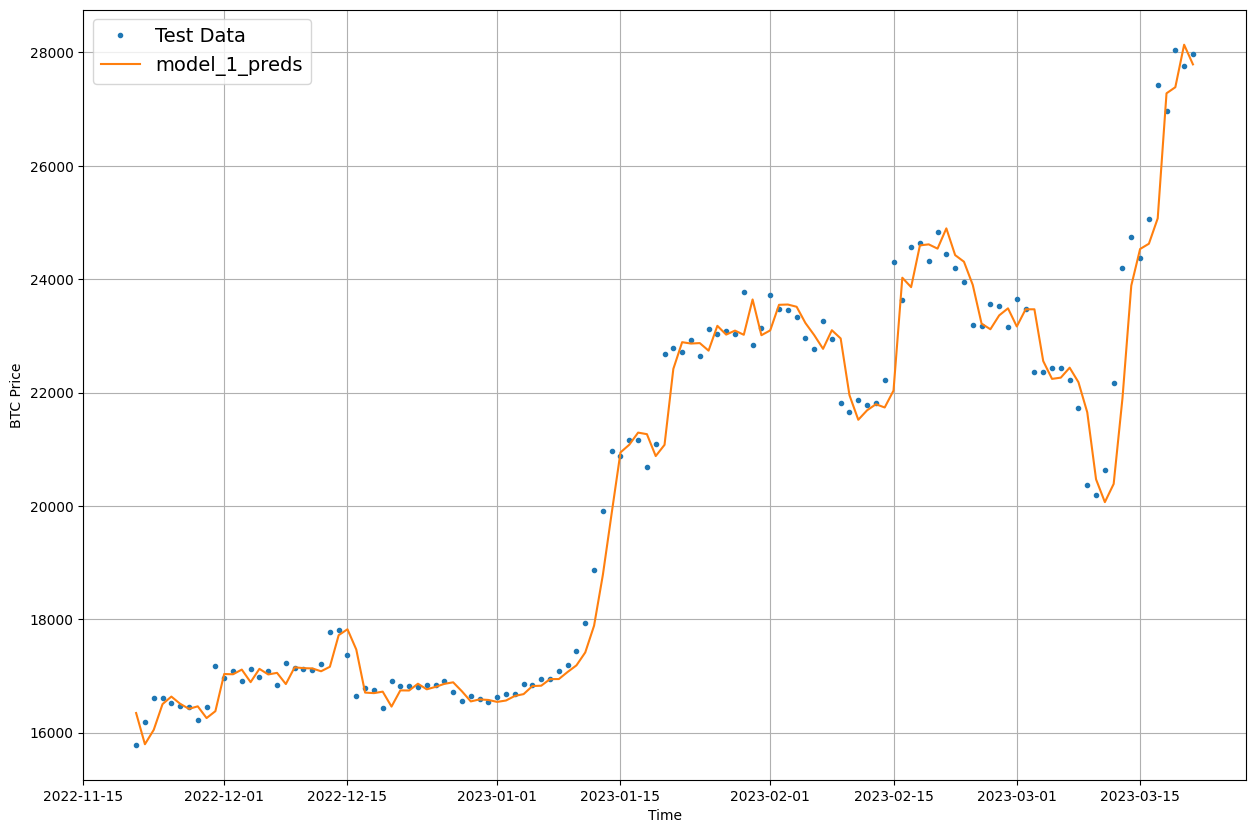

In [45]:
offset = 500
plt.figure(figsize=(15, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-",label="model_1_preds")

Something wrong with the predictions ? 

And also predictions are little behind the actual values. For more about this, [Read Autocorrelation](https://otexts.com/fpp3/acf.html)

Since they're on the test dataset. So they're not actual forecasts that we are trying for predicting a price.

With our current model setup, we've to make forecasts for the future.

## Model 2: Dense (window=30, horizon=1)

In this model we are going to predict on window_size 30, that is past 30 days of bitcoin prices to predict next day of bitcoin price.

In [46]:
HORIZON=1
WINDOW_SIZE=30

In [47]:
# Reset the windows and labels with 30 day prices of bitcoin
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:2], full_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996],
        [391.441986]]))

In [48]:
# Create train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2462, 616, 2462, 616)

In [49]:
# Now ready to create our dense model

tf.random.set_seed(17)

# Create the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], 'model_2_dense')

# compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [50]:
# evaluate the model with the last epochs 
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 990.7485


990.7484741210938

In [51]:
# Evaluation on the best model
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 863.9001


863.9000854492188

In [52]:
# prediction on model_2
model_2_preds = make_predictions(model_2, test_windows)

# evaluate the results
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

20/20 [==============================] - 0s 1ms/step


{'mae': 863.90015,
 'mse': 1718020.0,
 'rmse': 1310.7327,
 'mape': 2.5028338,
 'mase': 0.99996686}

In [53]:
model_1_results

{'mae': 828.8,
 'mse': 1552252.5,
 'rmse': 1245.8943,
 'mape': 2.4086208,
 'mase': 1.0000143}

It looks like `model_1` performs better than `model_2`.

Also, smaller windows size is performing better so in that case we can create window size of something like 5 days.



How do the predictions look ?

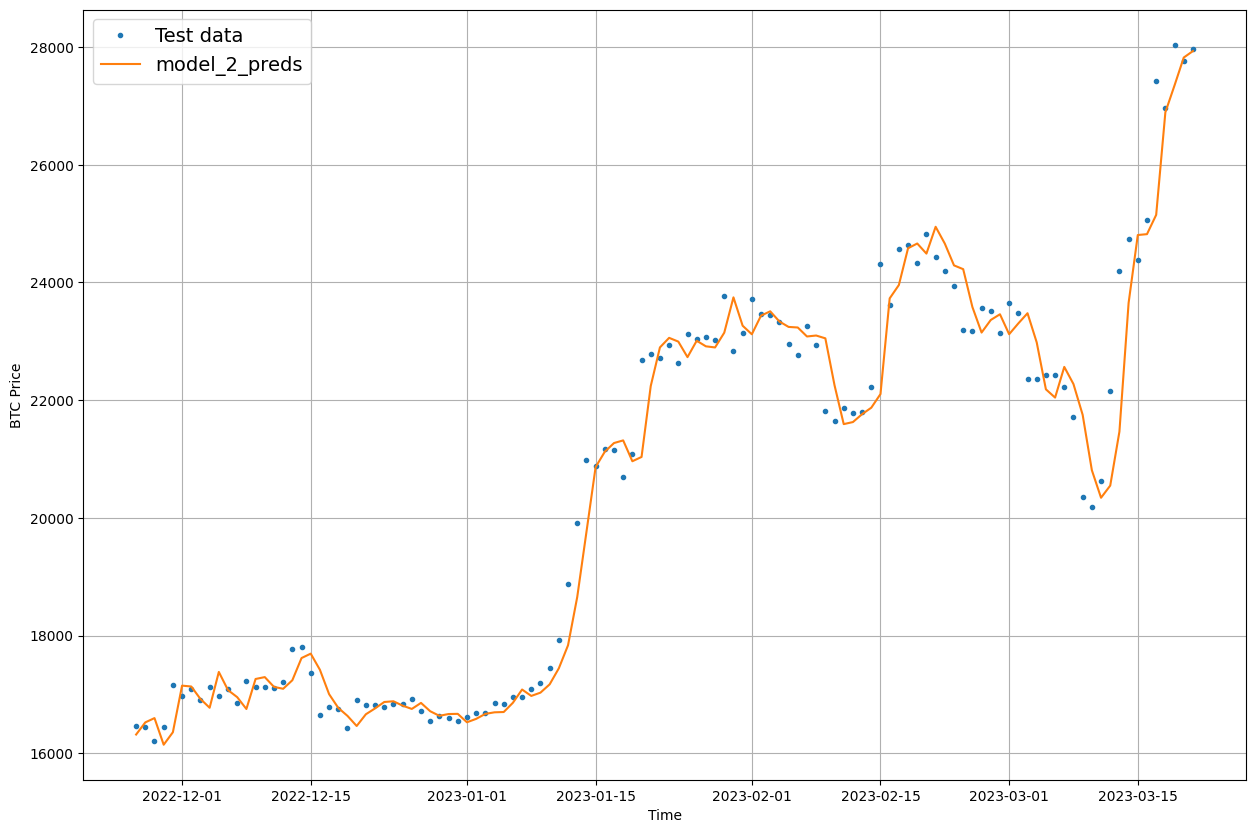

In [54]:
offset = 500
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3 : Dense(window=30, horizon=7)

In [55]:
HORIZON=7
WINDOW_SIZE=30

# create windows and labels
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
         383.15799 , 358.416992],
        [391.441986, 389.54599 , 382.845001, 386.475006, 383.1579

In [56]:
len(train_windows), len(test_windows)

(2457, 615)

In [57]:
tf.random.set_seed(17)

# Create Model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [58]:
# evaluation on last epoch
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1782.2659


1782.265869140625

In [59]:
# load the best model and evaluate
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1763.2577


1763.2576904296875

This is going to be large because we are trying to predict 7 days in advance, for example we want to predict the weather in advance of 7 days. So there will be higher chances of wrong predictibility.

In [60]:
# Make prediction and see the results
model_3_preds = make_predictions(model_3, test_windows)

20/20 [==============================] - 0s 1ms/step


In [61]:
model_3_preds.shape, test_labels.shape

(TensorShape([615, 7]), (615, 7))

In [62]:
# view the results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': array([ 412.53125, 1191.656  , 1253.2806 , 2134.2258 , 1479.6439 ,
        1003.00555, 1044.867  ,  922.3672 ,  923.2006 , 1756.9766 ,
        1799.76   , 3005.4868 , 4693.6597 , 4958.3154 , 5356.712  ,
        5150.1797 , 5256.2607 , 5093.3135 , 3914.4119 , 1599.8644 ,
        1006.16797, 1097.7823 , 1925.0408 , 2165.0352 , 2247.7378 ,
        2805.5222 , 4656.0073 , 4947.0034 , 4248.234  , 3445.799  ,
        2260.234  , 1956.5916 ,  925.4308 , 1200.3181 , 1125.7461 ,
        1315.1027 , 1411.4119 , 1526.6573 , 1814.2595 , 2407.1042 ,
        2676.4543 , 3034.5317 , 2280.7522 ,  970.5921 , 1231.3225 ,
        1556.8348 , 1929.4727 , 1011.0106 , 1649.972  ,  732.5458 ,
        1170.1964 , 1095.9688 , 1418.9314 , 2216.0212 , 2265.2166 ,
        2523.7288 , 2475.3694 , 3207.0183 , 3911.0798 , 4713.2744 ,
        6910.7886 , 4131.093  , 1717.1384 , 1071.029  , 1500.015  ,
        2234.2053 , 2237.7544 , 2702.5295 , 2562.4744 , 2808.3042 ,
        3173.7356 , 3946.0117 , 5053.259 

This is multi-dimensional output because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this we need to adjust our `evaluate_preds()` function.

In [63]:
tf.reduce_mean(model_3_results['mae'])

<tf.Tensor: shape=(), dtype=float32, numpy=1763.2577>

In [64]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # If horizon is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Let's evaulate our `model_3` now

In [65]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1763.2577,
 'mse': 6535884.5,
 'rmse': 2018.3182,
 'mape': 5.2199864,
 'mase': 0.99998134}

In [66]:
model_2_results

{'mae': 863.90015,
 'mse': 1718020.0,
 'rmse': 1310.7327,
 'mape': 2.5028338,
 'mase': 0.99996686}

`model_3` seems even worse compared to previous modelling experiments. Let's plot the predictions.

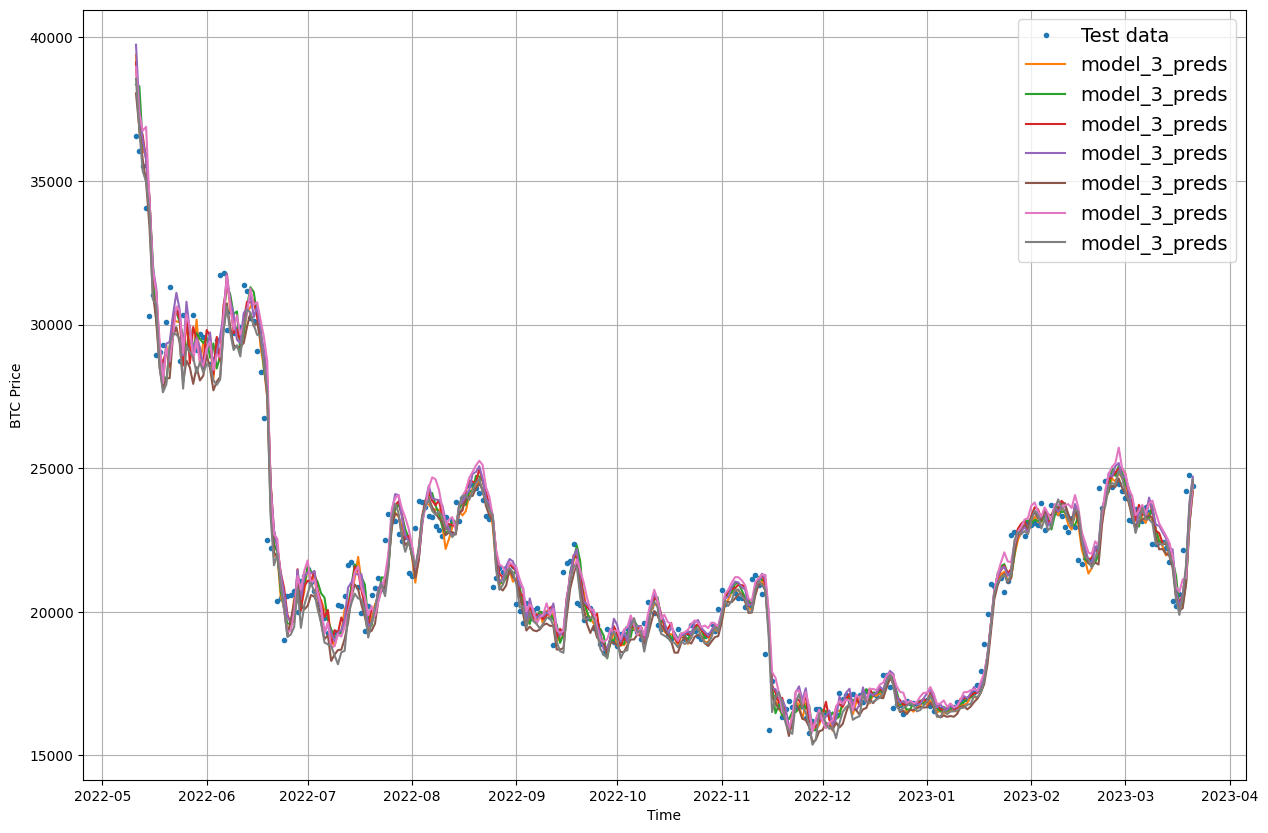

In [67]:
offset=300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,start=offset,format="-", label="model_3_preds")

Since our predictions were multi-dimensional, the plot predictions also look like stacked every timesteps together.

Let's fix this by aggregating our model's predictions.

**Note**: Aggregating the results of the predictions lead to lose in information from it's original predictions because it was originally predicted for 7 days but if we aggregate it in 1 day then it'll lose the detailed predictions.

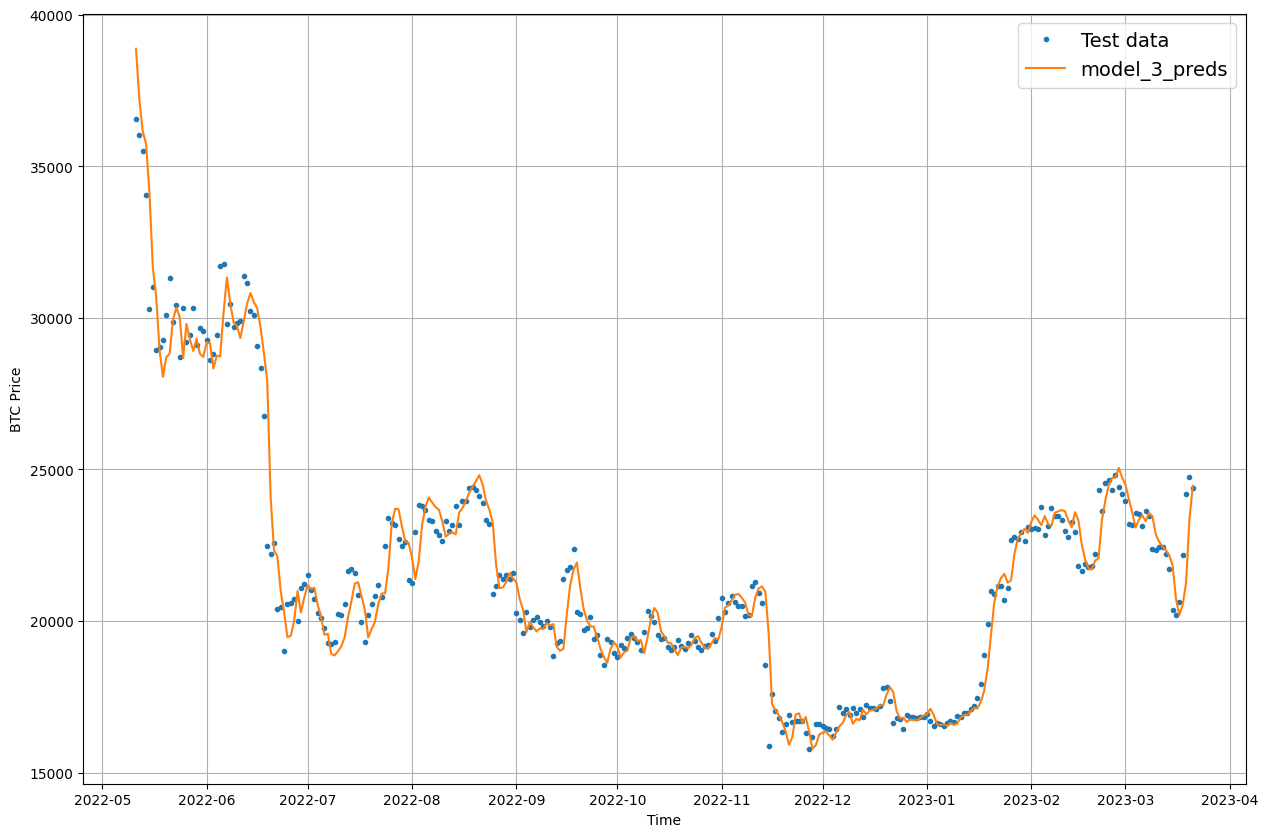

In [68]:
offset = 300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-" ,label="model_3_preds")

## Which of our model is performing best so far ?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naive model to see which model is performing the best so far.

<Axes: >

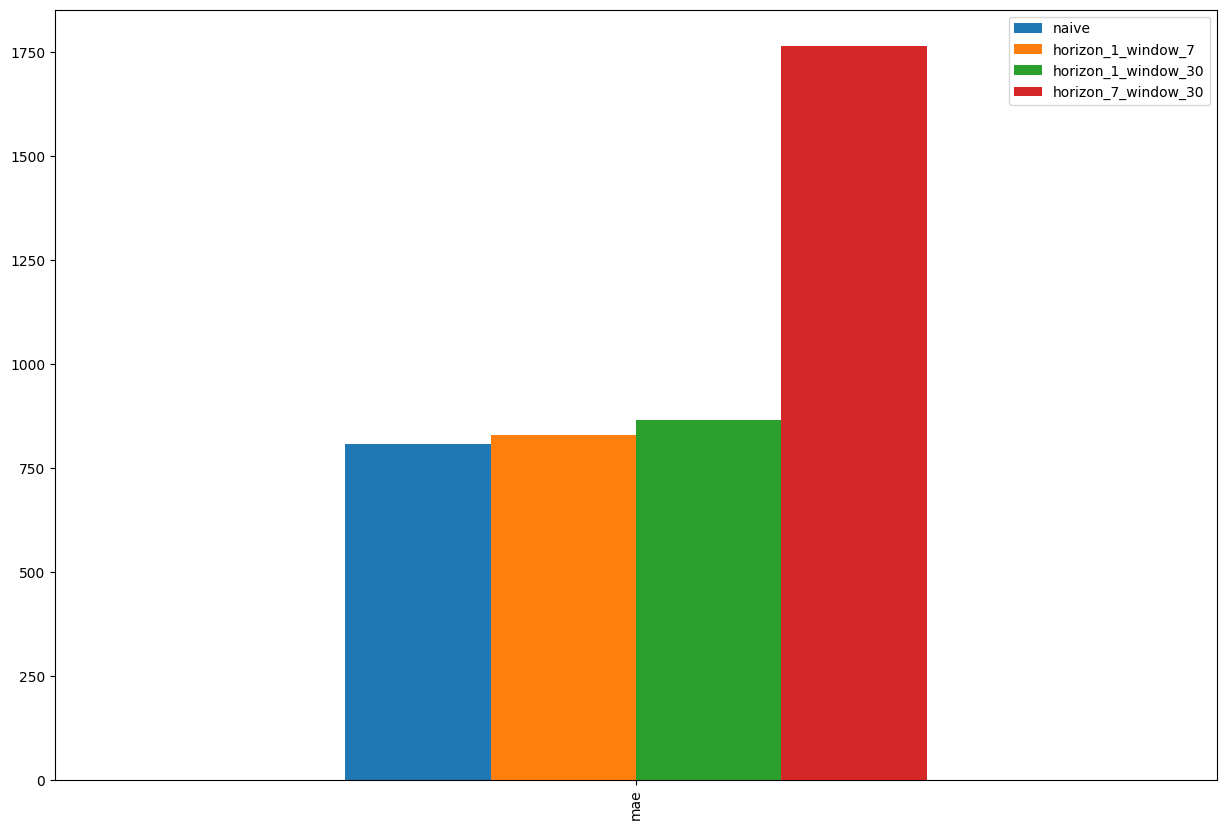

In [69]:
pd.DataFrame({"naive":naive_results['mae'],
              "horizon_1_window_7":model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=["mae"]).plot(kind='bar', figsize=(15,10))

Naive model is hard to beat in an open system, but `model_1` with HORIZON 1 and WINDOW SIZE 7 looks to be performing closest. So let's continue our experiments with only these set of horizon and window size.

💡 **Resource**: Due to autocorrelation in the time series data, naive model often performs best because the value of `t` will be closer to `t-1`. Today's value is probably pretty close to yesterday's value. This isn't always the case but when it is, a naive model will often get fairly good results.

Some more about how autocorrelation influences a model's predictions, [How (not) to use Machine learning for Time series forecasting : Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

## Model 4 : Conv1D

We'll be using Conv1D model as it can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is many to one problem).

In [70]:
HORIZON=1
WINDOW_SIZE=7

In [71]:
# make windows for Conv1D model
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2480, 2480, 621, 621)

In [72]:
# let's see how our training data looks like
train_windows[0]

array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])

In [73]:
# convert into tensors
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

Alright, it says the shape is 7 which is the window size. But if we see the doc of [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to convert the shape of inputs into `batch size + (timesteps, input_dim)`

In [74]:
# check the shape
x.shape

TensorShape([7])

We need to convert this into (7,1). Let's create a expand dim layer to convert the inputs shape inside the layer.

In [75]:
expand_dim_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [76]:
# Test it with the x 
expand_dim_layer(x)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[457.334],
       [424.44 ],
       [394.796],
       [408.904],
       [398.821],
       [402.152],
       [435.791]], dtype=float32)>

In [77]:
# Create the model

tf.random.set_seed(17)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
17/20 [========================>.....] - ETA: 0s - loss: 5306.2671  

20/20 [==============================] - 6s 47ms/step - loss: 4772.3662 - val_loss: 2151.9583
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 961.0062 - val_loss: 2826.3938
Epoch 3/100
18/20 [==========================>...] - ETA: 0s - loss: 590.8190

20/20 [==============================] - 1s 38ms/step - loss: 590.0325 - val_loss: 1612.2251
Epoch 4/100
17/20 [========================>.....] - ETA: 0s - loss: 518.8690

20/20 [==============================] - 1s 42ms/step - loss: 499.6508 - val_loss: 1563.6381
Epoch 5/100
14/20 [====================>.........] - ETA: 0s - loss: 474.5330

20/20 [==============================] - 1s 52ms/step - loss: 475.0093 - val_loss: 1520.2480
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 469.0098 - val_loss: 1534.5642
Epoch 7/100
13/20 [==================>...........] - ETA: 0s - loss: 472.5811

20/20 [==============================] - 1s 49ms/step - loss: 460.3781 - val_loss: 1474.5627
Epoch 8/100
18/20 [==========================>...] - ETA: 0s - loss: 461.2401

20/20 [==============================] - 1s 38ms/step - loss: 468.2121 - val_loss: 1438.3151
Epoch 9/100
18/20 [==========================>...] - ETA: 0s - loss: 445.0777

20/20 [==============================] - 1s 37ms/step - loss: 448.6387 - val_loss: 1423.3110
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 437.6860 - val_loss: 1466.2734
Epoch 11/100
18/20 [==========================>...] - ETA: 0s - loss: 430.0304

20/20 [==============================] - 1s 51ms/step - loss: 433.7059 - val_loss: 1409.0724
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 433.3739 - val_loss: 1536.5103
Epoch 13/100
18/20 [==========================>...] - ETA: 0s - loss: 432.9493

20/20 [==============================] - 1s 36ms/step - loss: 428.1566 - val_loss: 1303.1167
Epoch 14/100
20/20 [==============================] - 0s 6ms/step - loss: 401.9712 - val_loss: 1430.1565
Epoch 15/100
20/20 [==============================] - 0s 6ms/step - loss: 391.8379 - val_loss: 1513.5450
Epoch 16/100
18/20 [==========================>...] - ETA: 0s - loss: 392.5715

20/20 [==============================] - 1s 36ms/step - loss: 389.3011 - val_loss: 1229.5503
Epoch 17/100
20/20 [==============================] - 0s 6ms/step - loss: 375.0898 - val_loss: 1407.4972
Epoch 18/100
19/20 [===========================>..] - ETA: 0s - loss: 371.1659

20/20 [==============================] - 1s 36ms/step - loss: 375.8475 - val_loss: 1169.2578
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 363.7045 - val_loss: 1281.5745
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 368.6052 - val_loss: 1219.9797
Epoch 21/100
16/20 [=======================>......] - ETA: 0s - loss: 347.8863

20/20 [==============================] - 1s 36ms/step - loss: 347.6879 - val_loss: 1158.6316
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 340.8728 - val_loss: 1160.2394
Epoch 23/100
20/20 [==============================] - 0s 6ms/step - loss: 350.8750 - val_loss: 1166.2343
Epoch 24/100
18/20 [==========================>...] - ETA: 0s - loss: 360.2888

20/20 [==============================] - 1s 37ms/step - loss: 352.1380 - val_loss: 1074.9689
Epoch 25/100
18/20 [==========================>...] - ETA: 0s - loss: 330.3351

20/20 [==============================] - 1s 37ms/step - loss: 327.3199 - val_loss: 1033.6527
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 318.4789 - val_loss: 1062.4197
Epoch 27/100
18/20 [==========================>...] - ETA: 0s - loss: 318.8200

20/20 [==============================] - 1s 37ms/step - loss: 321.0131 - val_loss: 1012.6506
Epoch 28/100
18/20 [==========================>...] - ETA: 0s - loss: 310.4308

20/20 [==============================] - 1s 37ms/step - loss: 314.4352 - val_loss: 992.6712
Epoch 29/100
20/20 [==============================] - 0s 5ms/step - loss: 304.8606 - val_loss: 992.8329
Epoch 30/100
18/20 [==========================>...] - ETA: 0s - loss: 298.3924

20/20 [==============================] - 1s 43ms/step - loss: 298.3654 - val_loss: 970.7407
Epoch 31/100
20/20 [==============================] - 0s 7ms/step - loss: 295.9734 - val_loss: 987.3792
Epoch 32/100
20/20 [==============================] - 0s 7ms/step - loss: 295.2823 - val_loss: 985.0806
Epoch 33/100
20/20 [==============================] - 0s 7ms/step - loss: 313.1770 - val_loss: 1165.5043
Epoch 34/100
20/20 [==============================] - 0s 7ms/step - loss: 295.0137 - val_loss: 979.6855
Epoch 35/100
14/20 [====================>.........] - ETA: 0s - loss: 274.6355

20/20 [==============================] - 1s 52ms/step - loss: 286.5283 - val_loss: 943.5583
Epoch 36/100
20/20 [==============================] - 0s 7ms/step - loss: 286.5590 - val_loss: 1014.2164
Epoch 37/100
20/20 [==============================] - 0s 7ms/step - loss: 287.2821 - val_loss: 945.7952
Epoch 38/100
17/20 [========================>.....] - ETA: 0s - loss: 287.9185

20/20 [==============================] - 1s 37ms/step - loss: 284.2090 - val_loss: 937.1467
Epoch 39/100
20/20 [==============================] - 0s 5ms/step - loss: 294.4590 - val_loss: 955.1504
Epoch 40/100
20/20 [==============================] - 0s 5ms/step - loss: 315.2192 - val_loss: 1437.8466
Epoch 41/100
20/20 [==============================] - 0s 5ms/step - loss: 344.6772 - val_loss: 1347.3438
Epoch 42/100
20/20 [==============================] - 0s 5ms/step - loss: 293.8432 - val_loss: 983.7979
Epoch 43/100
18/20 [==========================>...] - ETA: 0s - loss: 277.9893

20/20 [==============================] - 1s 53ms/step - loss: 277.2944 - val_loss: 911.1454
Epoch 44/100
20/20 [==============================] - 0s 6ms/step - loss: 280.4140 - val_loss: 939.6088
Epoch 45/100
20/20 [==============================] - 0s 5ms/step - loss: 288.0365 - val_loss: 918.4924
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 290.3308 - val_loss: 1088.4788
Epoch 47/100
17/20 [========================>.....] - ETA: 0s - loss: 279.7705

20/20 [==============================] - 1s 35ms/step - loss: 281.9883 - val_loss: 905.5266
Epoch 48/100
18/20 [==========================>...] - ETA: 0s - loss: 268.2901

20/20 [==============================] - 1s 36ms/step - loss: 269.8831 - val_loss: 900.8739
Epoch 49/100
20/20 [==============================] - 0s 6ms/step - loss: 271.7802 - val_loss: 917.3888
Epoch 50/100
20/20 [==============================] - 0s 5ms/step - loss: 270.9458 - val_loss: 912.7804
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 270.5231 - val_loss: 1015.2014
Epoch 52/100
18/20 [==========================>...] - ETA: 0s - loss: 272.4992

20/20 [==============================] - 1s 36ms/step - loss: 273.7924 - val_loss: 892.7133
Epoch 53/100
20/20 [==============================] - 0s 6ms/step - loss: 278.8253 - val_loss: 1083.8121
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 288.7150 - val_loss: 894.1641
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 269.6346 - val_loss: 1133.2162
Epoch 56/100
20/20 [==============================] - 0s 6ms/step - loss: 280.0921 - val_loss: 914.0963
Epoch 57/100
19/20 [===========================>..] - ETA: 0s - loss: 264.8640

20/20 [==============================] - 1s 37ms/step - loss: 267.1873 - val_loss: 891.8361
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 273.7411 - val_loss: 1037.1478
Epoch 59/100
20/20 [==============================] - 0s 5ms/step - loss: 279.1030 - val_loss: 905.4435
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 261.7087 - val_loss: 892.4918
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 266.4951 - val_loss: 916.6557
Epoch 62/100
20/20 [==============================] - 0s 6ms/step - loss: 269.9937 - val_loss: 984.7413
Epoch 63/100
17/20 [========================>.....] - ETA: 0s - loss: 274.8649

20/20 [==============================] - 1s 36ms/step - loss: 277.6947 - val_loss: 872.6427
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 291.8074 - val_loss: 987.6529
Epoch 65/100
20/20 [==============================] - 0s 5ms/step - loss: 279.9669 - val_loss: 1039.4354
Epoch 66/100
20/20 [==============================] - 0s 5ms/step - loss: 298.3962 - val_loss: 1312.3875
Epoch 67/100
20/20 [==============================] - 0s 5ms/step - loss: 304.3453 - val_loss: 954.1085
Epoch 68/100
20/20 [==============================] - 0s 5ms/step - loss: 278.7998 - val_loss: 981.7013
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 263.8878 - val_loss: 1102.9877
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 283.4748 - val_loss: 1124.0548
Epoch 71/100
19/20 [===========================>..] - ETA: 0s - loss: 278.8715

20/20 [==============================] - 1s 36ms/step - loss: 277.3850 - val_loss: 863.4017
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 258.9201 - val_loss: 987.2917
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 272.2550 - val_loss: 866.8131
Epoch 74/100
19/20 [===========================>..] - ETA: 0s - loss: 261.6969

20/20 [==============================] - 1s 36ms/step - loss: 260.2632 - val_loss: 858.5602
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 263.7584 - val_loss: 959.7149
Epoch 76/100
20/20 [==============================] - 0s 6ms/step - loss: 274.3866 - val_loss: 860.2224
Epoch 77/100
20/20 [==============================] - 0s 5ms/step - loss: 263.9653 - val_loss: 871.0966
Epoch 78/100
20/20 [==============================] - 0s 8ms/step - loss: 264.1945 - val_loss: 937.3249
Epoch 79/100
12/20 [=================>............] - ETA: 0s - loss: 269.0551

20/20 [==============================] - 1s 52ms/step - loss: 259.9079 - val_loss: 855.3277
Epoch 80/100
20/20 [==============================] - 0s 7ms/step - loss: 261.0197 - val_loss: 945.8942
Epoch 81/100
13/20 [==================>...........] - ETA: 0s - loss: 264.1803

20/20 [==============================] - 1s 51ms/step - loss: 261.8590 - val_loss: 851.2131
Epoch 82/100
20/20 [==============================] - 0s 5ms/step - loss: 278.7471 - val_loss: 1259.0950
Epoch 83/100
20/20 [==============================] - 0s 5ms/step - loss: 285.7729 - val_loss: 954.6666
Epoch 84/100
20/20 [==============================] - 0s 5ms/step - loss: 303.0414 - val_loss: 955.9899
Epoch 85/100
20/20 [==============================] - 0s 5ms/step - loss: 278.2417 - val_loss: 873.1588
Epoch 86/100
20/20 [==============================] - 0s 6ms/step - loss: 260.9395 - val_loss: 944.7385
Epoch 87/100
18/20 [==========================>...] - ETA: 0s - loss: 266.4006

20/20 [==============================] - 1s 35ms/step - loss: 265.2602 - val_loss: 847.7241
Epoch 88/100
20/20 [==============================] - 0s 5ms/step - loss: 254.6084 - val_loss: 880.3128
Epoch 89/100
18/20 [==========================>...] - ETA: 0s - loss: 267.4098

20/20 [==============================] - 1s 36ms/step - loss: 265.7461 - val_loss: 845.8761
Epoch 90/100
20/20 [==============================] - 0s 5ms/step - loss: 253.7659 - val_loss: 882.4440
Epoch 91/100
19/20 [===========================>..] - ETA: 0s - loss: 253.7773

20/20 [==============================] - 1s 54ms/step - loss: 253.1925 - val_loss: 843.8738
Epoch 92/100
20/20 [==============================] - 0s 6ms/step - loss: 256.9915 - val_loss: 912.9265
Epoch 93/100
20/20 [==============================] - 0s 5ms/step - loss: 260.4304 - val_loss: 868.8286
Epoch 94/100
20/20 [==============================] - 0s 7ms/step - loss: 255.8972 - val_loss: 1080.7240
Epoch 95/100
20/20 [==============================] - 0s 5ms/step - loss: 281.6743 - val_loss: 938.0021
Epoch 96/100
20/20 [==============================] - 0s 5ms/step - loss: 258.0046 - val_loss: 893.1624
Epoch 97/100
20/20 [==============================] - 0s 5ms/step - loss: 269.4363 - val_loss: 894.6829
Epoch 98/100
20/20 [==============================] - 0s 5ms/step - loss: 259.0643 - val_loss: 858.7894
Epoch 99/100
20/20 [==============================] - 0s 5ms/step - loss: 258.3470 - val_loss: 953.5836
Epoch 100/100
20/20 [==============================] - 0s 5ms/step - loss: 

In [78]:
# check the summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [79]:
# evaluate on the last epochs model
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 854.0992


854.0992431640625

In [80]:
# load the best model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 843.8738


843.873779296875

In [81]:
# make some predictions
model_4_preds = make_predictions(model_4, test_windows)

# evaluate the results
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                   y_pred=model_4_preds)

model_4_results

20/20 [==============================] - 0s 2ms/step


{'mae': 843.8738,
 'mse': 1597749.8,
 'rmse': 1264.0212,
 'mape': 2.448386,
 'mase': 1.0000143}

In [82]:
model_1_results

{'mae': 828.8,
 'mse': 1552252.5,
 'rmse': 1245.8943,
 'mape': 2.4086208,
 'mase': 1.0000143}

Close enough with `model_1` but not better than it. Let's continue our experiments.

## Model 5 : RNN (LSTM)

We can also use a recurrent neural network to model our sequential time series data.

We're not going to change the data, the data will be same just the model architecture would be different.

In [83]:
tf.random.set_seed(17)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_LSTM")

# compile the model
model_5.compile(loss='mae',
                optimizer='Adam')

# fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

In [84]:
# check the summary
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 205,377
Trainable params: 205,377
Non-tr

In [85]:
# evaluate on last epoch
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 836.6551


836.6550903320312

In [86]:
# load the best model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 836.6551


836.6550903320312

In [87]:
# make predictions and check pred results
model_5_preds = make_predictions(model_5, test_windows)

model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)

model_5_results

20/20 [==============================] - 0s 2ms/step


{'mae': 836.6551,
 'mse': 1563725.5,
 'rmse': 1250.4901,
 'mape': 2.4289348,
 'mase': 1.0000143}

## Make a Multivariate time series

So far all our models predicted on univariate time series data which is only Bitcoin prices, but what are other features that may impact the price of bitcoin, that's the thing to explore.


What about the Volume ? Or Block Reward ? Could be a tweet from a famous personality like Elon Musk can fluctuate the prices. 

According to the data we have, we can use Volume and Block Reward. Then let's add these two features into our time series dataset.

In [88]:
# view the dataset
bitcoin_prices.tail()

,Price
Date,
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781
2023-03-20,27767.236328
2023-03-21,27964.888672


According to the [CMC Markets](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving) block reward events, we can assign the block reward to specific date range in our dataset.

| Block Reward	| Start Date |
| --- | --- |
| 50	| 3 January 2009 (2009-01-03) |
| 25	| 28 November 2012 |
| 12.5 |	9 July 2016 |
| 6.25 |	11 May 2020 |
| 3.125	|TBA (expected 2024) |
| 1.5625 |	TBA (expected 2028) |


And we have a data between **`2014 Sept 17th`** - **`2023 March 17th`**. Great.


In [89]:
# Block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25
block_reward_5 = 3.125 # not required for our dataset

# Block reward dates
block_reward_1_date = np.datetime64("2009-01-03")
block_reward_2_date = np.datetime64("2012-11-28")
block_reward_3_date = np.datetime64("2016-07-09")
block_reward_4_date = np.datetime64("2020-05-11")
block_reward_5_date = np.datetime64("2024-04-01") # expected to be april

Let's get the number of days fall between the block reward dates in our time series dataset.

In [90]:
block_reward_2_days = (block_reward_3_date - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_date - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_5_date - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days, block_reward_4_days

(661, 2063, 3484)

Now add the new feature `block_reward` in our dataset.

In [91]:
# Add block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column
                          # row, column
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5

Let's view head and tail of data.

In [92]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [93]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-03-17,27423.929688,6.25
2023-03-18,26965.878906,6.25
2023-03-19,28038.675781,6.25
2023-03-20,27767.236328,6.25
2023-03-21,27964.888672,6.25


Let's plot it to see how it looks like together.

<Axes: xlabel='Date'>

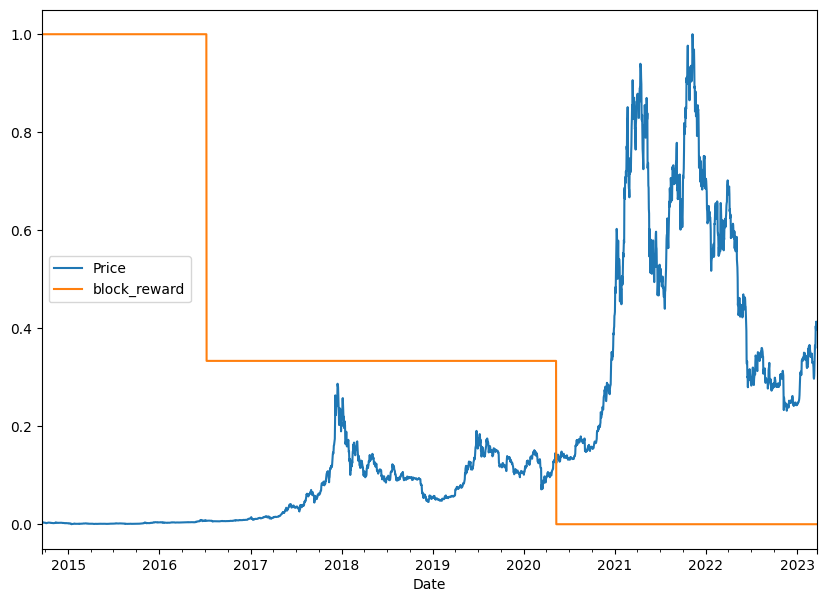

In [94]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

In the above plot when we set the same scale for prices and block reward, we can see the Prices go up when block reward get reduced.

## Making a windowed dataset with pandas

Previously we created some custom function to window our univariate time series.

Since we have added one more variable to our dataset, these functions won't work.

In pandas, there is a function called [`.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html), which can be used to create windows on multivariate time series dataset.


In [95]:
# Setup dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [96]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)               

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


Alright, we need to drop NaNs and make feature set and label set.

In [97]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

# Make train test split
split_size = int(len(X) * 0.8) # 80%
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

X_train.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [98]:
X_train.shape, X_test.shape

((2480, 8), (621, 8))

## Model 6 : Multivariate Time Series (Dense model)

We're going to build the same model like `model_1` architecture and use it to train and make predictions on our multivariate time series data.

In [99]:
tf.random.set_seed(17)

# Create the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], "model_6_multivariate_dense")

# Compile the model
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name="model_6_multivariate_dense")])

Epoch 1/100
 1/20 [>.............................] - ETA: 16s - loss: 10448.1504

20/20 [==============================] - 1s 33ms/step - loss: 6720.2212 - val_loss: 4853.5332
Epoch 2/100
17/20 [========================>.....] - ETA: 0s - loss: 1069.3441

20/20 [==============================] - 1s 27ms/step - loss: 989.6866 - val_loss: 2121.0383
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 702.7334

20/20 [==============================] - 1s 26ms/step - loss: 561.2419 - val_loss: 1339.0825
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 422.9150 - val_loss: 1341.8600
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 403.9132

20/20 [==============================] - 1s 30ms/step - loss: 400.2155 - val_loss: 1280.6298
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 392.6716 - val_loss: 1387.0221
Epoch 7/100
17/20 [========================>.....] - ETA: 0s - loss: 387.4476

20/20 [==============================] - 1s 37ms/step - loss: 388.6894 - val_loss: 1237.8335
Epoch 8/100
15/20 [=====================>........] - ETA: 0s - loss: 383.1216

20/20 [==============================] - 1s 37ms/step - loss: 408.0067 - val_loss: 1226.4796
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 365.3614 - val_loss: 1230.7220
Epoch 10/100
15/20 [=====================>........] - ETA: 0s - loss: 363.2131

20/20 [==============================] - 1s 29ms/step - loss: 359.0114 - val_loss: 1200.2107
Epoch 11/100
20/20 [==============================] - 0s 4ms/step - loss: 352.6410 - val_loss: 1235.7327
Epoch 12/100
 1/20 [>.............................] - ETA: 0s - loss: 463.4208

20/20 [==============================] - 0s 25ms/step - loss: 350.8542 - val_loss: 1143.9113
Epoch 13/100
 1/20 [>.............................] - ETA: 0s - loss: 411.0198

20/20 [==============================] - 0s 25ms/step - loss: 339.1270 - val_loss: 1136.4982
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 333.5172 - val_loss: 1323.3827
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 335.5964 - val_loss: 1174.5964
Epoch 16/100
20/20 [==============================] - ETA: 0s - loss: 330.2086

20/20 [==============================] - 1s 44ms/step - loss: 330.2086 - val_loss: 1055.9789
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 321.6574 - val_loss: 1176.5654
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 315.3690 - val_loss: 1125.9641
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 316.8333 - val_loss: 1309.5906
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 327.6009 - val_loss: 1222.1188
Epoch 21/100
 1/20 [>.............................] - ETA: 0s - loss: 376.0206

20/20 [==============================] - 0s 25ms/step - loss: 312.2702 - val_loss: 998.2496
Epoch 22/100
20/20 [==============================] - 0s 6ms/step - loss: 307.5107 - val_loss: 1058.7825
Epoch 23/100
20/20 [==============================] - 0s 4ms/step - loss: 303.2152 - val_loss: 1312.8529
Epoch 24/100
20/20 [==============================] - 0s 5ms/step - loss: 330.9513 - val_loss: 1251.6244
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 301.6661

20/20 [==============================] - 0s 25ms/step - loss: 301.6661 - val_loss: 991.3212
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 290.4958 - val_loss: 1032.2474
Epoch 27/100
20/20 [==============================] - 0s 5ms/step - loss: 304.0361 - val_loss: 1033.4205
Epoch 28/100
20/20 [==============================] - 0s 4ms/step - loss: 295.2788 - val_loss: 1001.5248
Epoch 29/100
20/20 [==============================] - 0s 4ms/step - loss: 297.0196 - val_loss: 1002.2773
Epoch 30/100
 1/20 [>.............................] - ETA: 0s - loss: 220.1725

20/20 [==============================] - 1s 26ms/step - loss: 286.1213 - val_loss: 950.4364
Epoch 31/100
20/20 [==============================] - 0s 5ms/step - loss: 284.7052 - val_loss: 977.2057
Epoch 32/100
20/20 [==============================] - 0s 5ms/step - loss: 284.9863 - val_loss: 1000.2628
Epoch 33/100
20/20 [==============================] - 0s 4ms/step - loss: 296.1643 - val_loss: 1041.8850
Epoch 34/100
20/20 [==============================] - 0s 5ms/step - loss: 281.7980 - val_loss: 956.0873
Epoch 35/100
20/20 [==============================] - 0s 4ms/step - loss: 285.7543 - val_loss: 965.6161
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 282.1163 - val_loss: 1016.0112
Epoch 37/100
20/20 [==============================] - ETA: 0s - loss: 284.7999

20/20 [==============================] - 1s 27ms/step - loss: 284.7999 - val_loss: 909.1025
Epoch 38/100
20/20 [==============================] - 0s 5ms/step - loss: 276.3812 - val_loss: 977.7170
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 285.1274 - val_loss: 938.4667
Epoch 40/100
20/20 [==============================] - 0s 5ms/step - loss: 302.2684 - val_loss: 1216.9938
Epoch 41/100
20/20 [==============================] - 0s 4ms/step - loss: 315.4135 - val_loss: 1301.8933
Epoch 42/100
20/20 [==============================] - 0s 5ms/step - loss: 290.3014 - val_loss: 930.1735
Epoch 43/100
 1/20 [>.............................] - ETA: 0s - loss: 309.6669

20/20 [==============================] - 0s 25ms/step - loss: 270.4078 - val_loss: 890.8468
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 275.4462 - val_loss: 909.1774
Epoch 45/100
 1/20 [>.............................] - ETA: 0s - loss: 233.7541

20/20 [==============================] - 0s 25ms/step - loss: 277.2389 - val_loss: 885.8012
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 280.0264 - val_loss: 1047.9832
Epoch 47/100
 1/20 [>.............................] - ETA: 0s - loss: 202.3758

20/20 [==============================] - 0s 25ms/step - loss: 275.7811 - val_loss: 883.7837
Epoch 48/100
20/20 [==============================] - 0s 5ms/step - loss: 266.7801 - val_loss: 906.7501
Epoch 49/100
20/20 [==============================] - 0s 4ms/step - loss: 265.8534 - val_loss: 890.6525
Epoch 50/100
 1/20 [>.............................] - ETA: 0s - loss: 371.2069

20/20 [==============================] - 1s 26ms/step - loss: 264.1560 - val_loss: 877.9235
Epoch 51/100
20/20 [==============================] - 0s 4ms/step - loss: 264.6248 - val_loss: 879.2244
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 261.7975 - val_loss: 884.4319
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 270.6974 - val_loss: 965.1613
Epoch 54/100
20/20 [==============================] - ETA: 0s - loss: 269.5846

20/20 [==============================] - 0s 25ms/step - loss: 269.5846 - val_loss: 866.9178
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 266.1217 - val_loss: 1039.9458
Epoch 56/100
 1/20 [>.............................] - ETA: 0s - loss: 389.6749

20/20 [==============================] - 1s 31ms/step - loss: 281.5760 - val_loss: 865.3535
Epoch 57/100
15/20 [=====================>........] - ETA: 0s - loss: 268.5495

20/20 [==============================] - 1s 37ms/step - loss: 268.1963 - val_loss: 864.8446
Epoch 58/100
20/20 [==============================] - 0s 6ms/step - loss: 271.1927 - val_loss: 1076.6064
Epoch 59/100
20/20 [==============================] - 0s 6ms/step - loss: 267.3862 - val_loss: 868.6858
Epoch 60/100
20/20 [==============================] - 0s 6ms/step - loss: 259.0605 - val_loss: 865.3408
Epoch 61/100
20/20 [==============================] - 0s 6ms/step - loss: 266.0251 - val_loss: 889.9508
Epoch 62/100
20/20 [==============================] - 0s 7ms/step - loss: 272.2702 - val_loss: 925.1349
Epoch 63/100
20/20 [==============================] - 0s 6ms/step - loss: 273.4787 - val_loss: 869.4563
Epoch 64/100
20/20 [==============================] - 0s 6ms/step - loss: 292.8294 - val_loss: 1088.1569
Epoch 65/100
20/20 [==============================] - 0s 6ms/step - loss: 275.4061 - val_loss: 1019.1353
Epoch 66/100
20/20 [==============================] - 0s 6ms/step - loss:

20/20 [==============================] - 0s 25ms/step - loss: 281.3568 - val_loss: 844.6538
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 255.6830 - val_loss: 1016.6377
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 267.9418 - val_loss: 860.5092
Epoch 74/100
20/20 [==============================] - 0s 4ms/step - loss: 253.5574 - val_loss: 844.6779
Epoch 75/100
20/20 [==============================] - 0s 4ms/step - loss: 256.2327 - val_loss: 864.0950
Epoch 76/100
20/20 [==============================] - 0s 4ms/step - loss: 259.8829 - val_loss: 847.4048
Epoch 77/100
 1/20 [>.............................] - ETA: 0s - loss: 297.8959

20/20 [==============================] - 1s 27ms/step - loss: 257.4296 - val_loss: 841.1053
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 266.9083 - val_loss: 988.3536
Epoch 79/100
20/20 [==============================] - 0s 5ms/step - loss: 265.9613 - val_loss: 875.9220
Epoch 80/100
20/20 [==============================] - 0s 4ms/step - loss: 260.6057 - val_loss: 887.5942
Epoch 81/100
 1/20 [>.............................] - ETA: 0s - loss: 276.0073

20/20 [==============================] - 1s 26ms/step - loss: 257.6222 - val_loss: 840.7494
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 268.6826 - val_loss: 1226.9900
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 289.6131 - val_loss: 950.4788
Epoch 84/100
20/20 [==============================] - 0s 5ms/step - loss: 307.9830 - val_loss: 1051.5427
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 278.6524 - val_loss: 988.4533
Epoch 86/100
20/20 [==============================] - 0s 5ms/step - loss: 265.0772 - val_loss: 929.6788
Epoch 87/100
 1/20 [>.............................] - ETA: 0s - loss: 217.5800

20/20 [==============================] - 0s 24ms/step - loss: 261.9795 - val_loss: 836.7949
Epoch 88/100
20/20 [==============================] - 0s 5ms/step - loss: 253.8770 - val_loss: 860.2817
Epoch 89/100
 1/20 [>.............................] - ETA: 0s - loss: 311.9733

20/20 [==============================] - 0s 26ms/step - loss: 258.1251 - val_loss: 833.3818
Epoch 90/100
20/20 [==============================] - 0s 5ms/step - loss: 249.8459 - val_loss: 875.9136
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 251.0201 - val_loss: 840.3182
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 254.0461 - val_loss: 906.7045
Epoch 93/100
20/20 [==============================] - 0s 4ms/step - loss: 256.1332 - val_loss: 833.7642
Epoch 94/100
20/20 [==============================] - 0s 5ms/step - loss: 255.7925 - val_loss: 1133.4656
Epoch 95/100
20/20 [==============================] - 0s 4ms/step - loss: 289.4580 - val_loss: 889.6605
Epoch 96/100
20/20 [==============================] - 0s 4ms/step - loss: 256.5931 - val_loss: 912.5447
Epoch 97/100
20/20 [==============================] - 0s 5ms/step - loss: 274.6003 - val_loss: 908.9579
Epoch 98/100
20/20 [==============================] - 0s 5ms/step - loss: 2

In [100]:
# evaluate on last epoch
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 834.2874


834.2874145507812

In [101]:
# load the best model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_multivariate_dense/")
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 833.3817


833.3817138671875

In [102]:
# Make prediction
model_6_preds = make_predictions(model_6, X_test)

model_6_preds[:2]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([32908.01 , 33580.926], dtype=float32)>

In [103]:
# evaluate preds
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 833.38184,
 'mse': 1561068.9,
 'rmse': 1249.4274,
 'mape': 2.4060025,
 'mase': 1.0000143}

In [104]:
model_1_results

{'mae': 828.8,
 'mse': 1552252.5,
 'rmse': 1245.8943,
 'mape': 2.4086208,
 'mase': 1.0000143}

Oh great, we got the almost the same results as `model_1` but still `naive forecast` is the best so far.

In [105]:
naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

## Model 7 : N-BEATS Algorithm

So far we've tried on smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Bases Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state of the art performance in the winner of the M4 competition (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm ([section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))



### Building and Testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

In [106]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each ReLu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [107]:
# set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [108]:
# create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [109]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.96771026  0.40825364  0.23296535 -0.11847873 -0.7400881  -0.953599
  0.20765214]
Forecast: -0.031731799244880676


### Preparing data for the N-BEATS algorithm using `tf.data`

This time, we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

In [110]:
HORIZON=1
WINDOW_SIZE=7

In [111]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [112]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [113]:
# Drop NaN & create feature and label dataset
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test split
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test)

(2480, 621)

In [114]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine the labels and features using .zip()
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Create the Batch and Prefetch the Datasets using batch() and prefetch()
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting Up Hyperparameters for N-BEATS algorithm

Setting up the hyperparameters for the N-BEATS architecture as mentioned in Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)


In [115]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before jump into creating N-BEATS model, there are two layers to go through which play a large role in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:

- `tf.keras.layers.subtract(inputs)`
- `tf.keras.layers.add(inputs)`

In [116]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract 
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

tensor_1, tensor_2, subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the `Keras Functional API` for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  - `tf.keras.callbacks.EarlyStopping()` - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)
  - `tf.keras.callbacks.ReduceLROnPlateau()` - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)


In [117]:
%%time

tf.random.set_seed(17)

# 1. Setup an instance of N-BEATS block layer using NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create an input layer for the N-BEATS stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Make the initial backcast and forecast
backcast, forecast = nbeats_block_layer(stack_input)
# Add in substraction residual link
residuals = layers.subtract([stack_input, backcast], name='subtract_00')

# 4. Use a for loop to create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)):
  # 5. Use the NBeatsBlock class within the for loop
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                         theta_size=THETA_SIZE,
                                         horizon=HORIZON,
                                         n_neurons=N_NEURONS,
                                         n_layers=N_LAYERS,
                                         name=f'NBeatsBlock_{i}')(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Put the model inputs and outputs together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name='model_7_NBeats')

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

# 9. Fit the model with EarlyStoppping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,            
            epochs=N_EPOCHS,
            verbose=0,
            validation_data=test_dataset,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])


Epoch 312: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 412: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 2min 9s, sys: 2.71 s, total: 2min 12s
Wall time: 2min 22s


In [118]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 26ms/step - loss: 831.5393 - mae: 831.5393 - mse: 1550555.5000


[831.539306640625, 831.539306640625, 1550555.5]

In [119]:
# make predictions
model_7_preds = make_predictions(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33063.73 , 33858.508, 33735.848, 34112.836, 33564.68 , 32803.844,
       32996.434, 31895.072, 31742.3  , 31499.414], dtype=float32)>

In [120]:
# evaluate results
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 831.5393,
 'mse': 1550555.5,
 'rmse': 1245.213,
 'mape': 2.4161966,
 'mase': 1.0000143}

In [121]:
naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

Even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fast not all the larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created



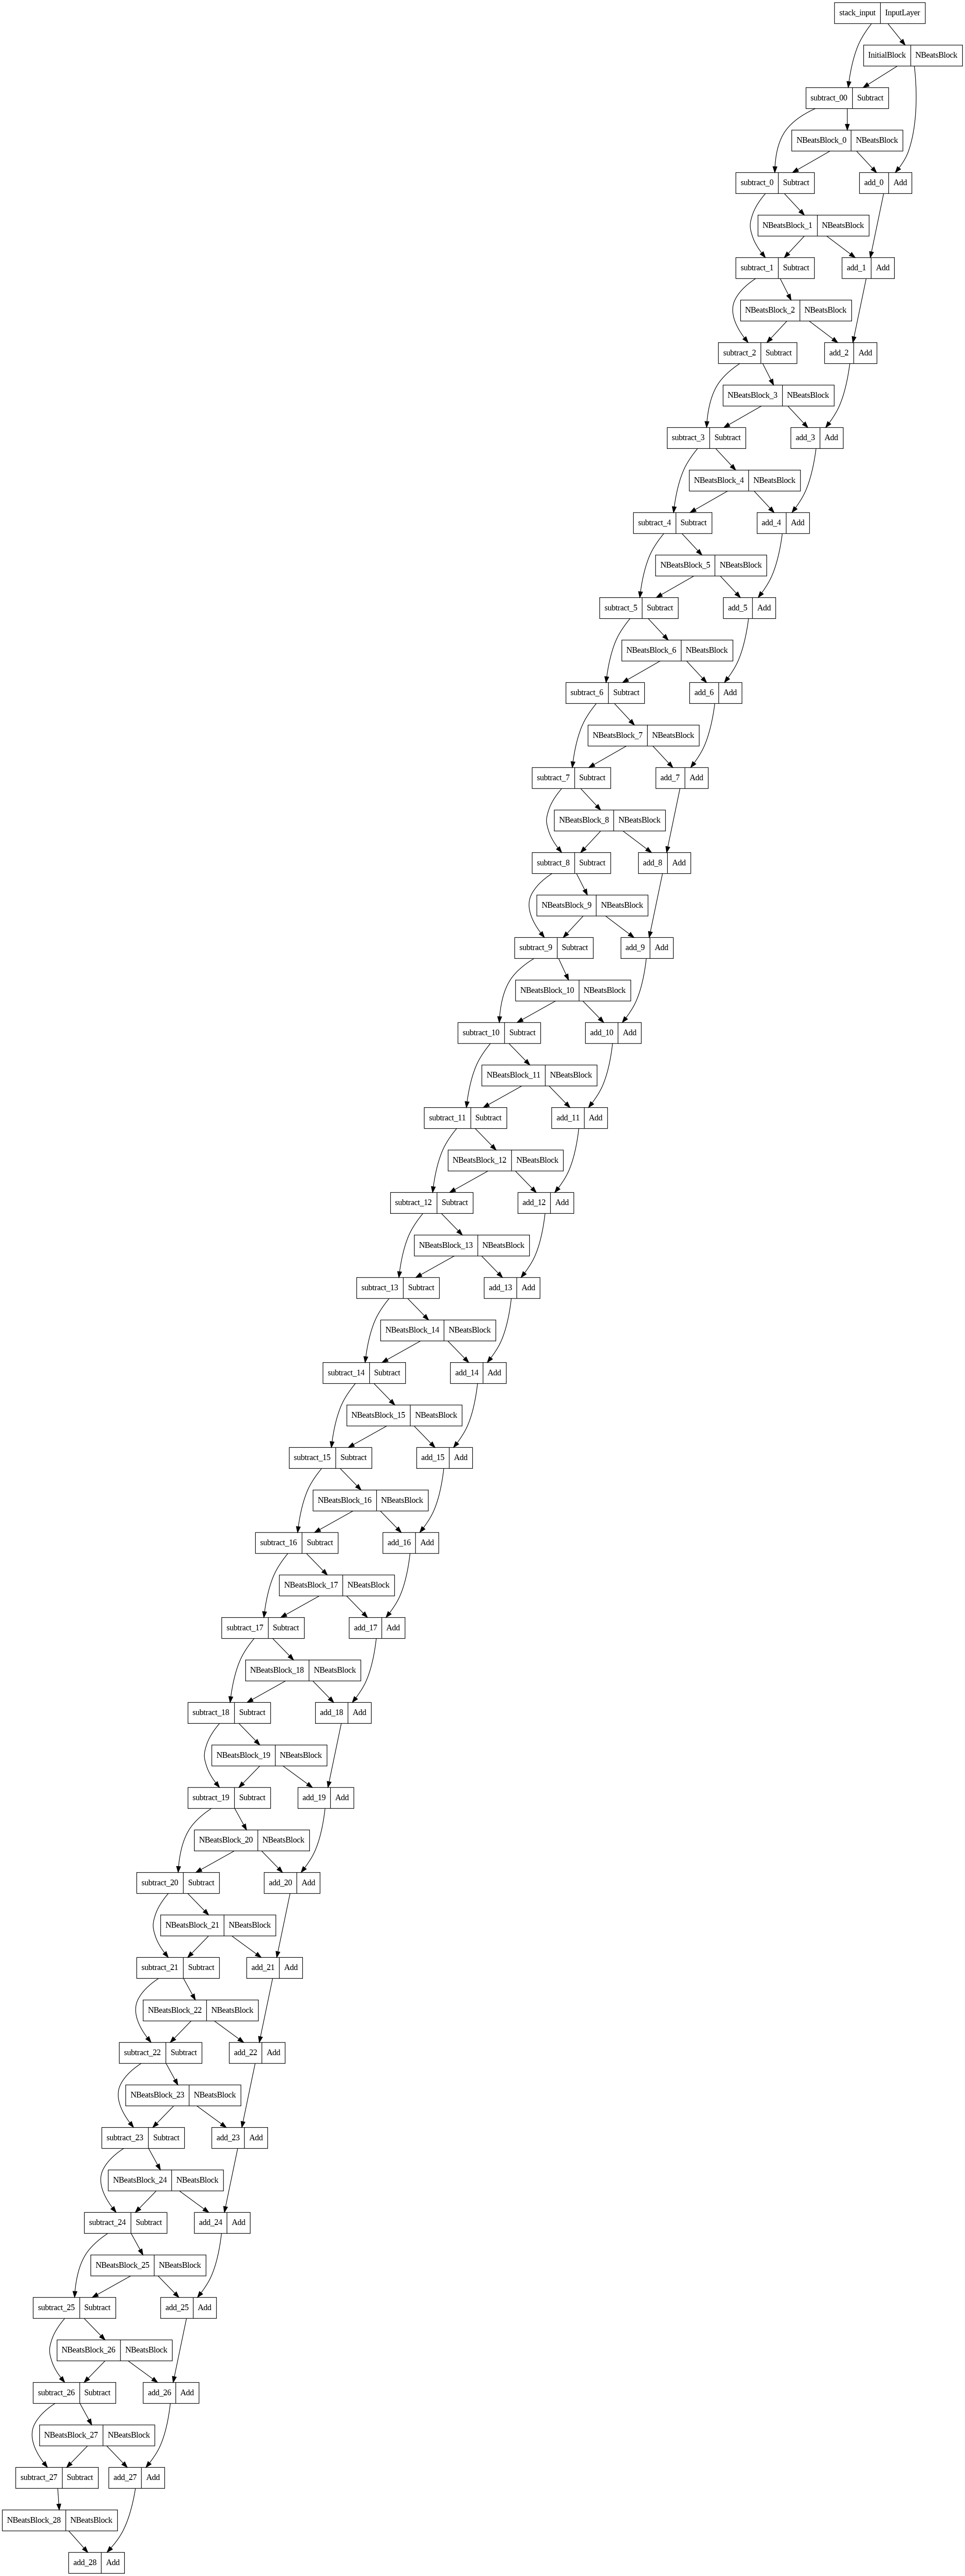

In [122]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8 : Creating an ensemble (stacking different models together)

Our next experiment is creating an [ensemble of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An ensemble involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like kaggle.

### Construction and fitting an ensemble of models (using different loss functions)

In [123]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned.
  10 * ["mae", "mse", "mape"]
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple dense model
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(HORIZON)
      ])

      # compile a model
      model.compile(loss=f"{loss_function}",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])
      
      # fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                patience=100,
                                                                verbose=1)])
      
      # append the fitted model
      ensemble_models.append(model)
  return ensemble_models

In [124]:
%%time
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 606: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 477: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 577: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 299: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 411: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 511: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 657: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 932: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by redu

In [125]:
# list out the ensemble models
ensemble_models

### Make predictions with ensemble models

In [126]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [127]:
# create the list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


<tf.Tensor: shape=(15, 621), dtype=float32, numpy=
array([[33183.383, 33833.266, 33573.938, ..., 27324.668, 28404.719,
        27807.86 ],
       [32899.79 , 33359.918, 33531.473, ..., 27418.498, 28154.502,
        28277.998],
       [32871.355, 33650.54 , 33557.766, ..., 27166.113, 27914.348,
        27794.33 ],
       ...,
       [32876.586, 33485.375, 33550.207, ..., 27413.836, 27975.11 ,
        28165.902],
       [32967.805, 33499.6  , 33443.21 , ..., 27478.703, 28095.39 ,
        28028.152],
       [32957.93 , 33778.625, 33447.555, ..., 27250.076, 28169.984,
        27793.553]], dtype=float32)>

Now we have got a set of ensemble predictions, we can evaluate them against the ground truth values.

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median or mean (but [median is usually more robust than mean](https://www.johndcook.com/blog/2009/03/06/student-t-distribution-mean-median/))



In [128]:
# evaluate ensemble predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))

ensemble_results

{'mae': 814.45276,
 'mse': 1510943.9,
 'rmse': 1229.2046,
 'mape': 2.3549144,
 'mase': 1.0000143}

In [129]:
model_1_results

{'mae': 828.8,
 'mse': 1552252.5,
 'rmse': 1245.8943,
 'mape': 2.4086208,
 'mase': 1.0000143}

In [130]:
naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

Looks like now we have a change in 2nd spot of best performing models, `ensemble models` performed better than `model_1` which was earlier in the 2nd spot.

### Plotting the prediction intervals (uncertainity estimates) of our ensemble

Right now all of our model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of `WINDOW_SIZE=7` values, the model will predict `HORIZON=1`.

But what might be more helpful than a single value ?

Perhaps a range of values ?

For example, if a model is predicting the price of Bitcoin to be 50,000USD tomorrow, would it be helpful to know it's predicting the 50,000USD because it's predicting the price to be between 48,000USD and 52,000USD?


Knowing the range of values of a model is predicting may help you make better decisions for your forecasts.

These kind of prediction ranges are called **prediction intervals** or **uncertainity estimates**. And they're often as important as the forecast itself.

Why ?

Because **point predictions** are almost always going to be wrong. So having a range of values can help with decision making.

One way of getting the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1).

In [131]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take predictions of multiple models
  # 2. Measure the std
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply std by 1.96
  interval = 1.96 * std

  # 4. get the prediction interval of lower and upper bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper


# Get the upper and lower
lower, upper = get_upper_lower(preds=ensemble_preds)

In [132]:
lower

<tf.Tensor: shape=(621,), dtype=float32, numpy=
array([32281.066 , 33052.953 , 33052.29  , 33654.69  , 32753.078 ,
       32091.322 , 32295.273 , 31233.469 , 30884.84  , 30930.191 ,
       31232.762 , 30533.355 , 29410.98  , 31341.064 , 31991.99  ,
       33010.598 , 33856.867 , 35003.438 , 36831.363 , 38999.55  ,
       39694.703 , 39656.137 , 41458.633 , 41615.22  , 39582.945 ,
       38608.21  , 37506.793 , 38401.7   , 40159.652 , 42008.04  ,
       43952.258 , 43703.766 , 45650.348 , 45451.65  , 45113.78  ,
       43782.6   , 46695.816 , 46640.414 , 46365.426 , 45331.46  ,
       43911.68  , 44013.78  , 45780.527 , 48523.93  , 48404.074 ,
       48824.19  , 49208.09  , 47310.434 , 48091.973 , 46503.44  ,
       47753.9   , 48135.79  , 47951.71  , 46388.68  , 46140.324 ,
       48143.156 , 48723.46  , 49241.17  , 49411.73  , 51165.938 ,
       52260.613 , 46550.33  , 45525.258 , 45347.105 , 44077.844 ,
       44338.383 , 44620.48  , 44473.625 , 46102.35  , 47600.594 ,
       47406.4

In [133]:
upper

<tf.Tensor: shape=(621,), dtype=float32, numpy=
array([33667.76 , 34220.516, 34106.156, 34777.785, 33890.11 , 33228.336,
       33240.297, 32466.79 , 32014.383, 31936.41 , 32294.703, 31410.922,
       30324.336, 32272.764, 32971.805, 34152.62 , 35023.188, 35995.33 ,
       38176.973, 40155.418, 41026.375, 41014.73 , 43122.844, 42591.75 ,
       40895.64 , 39702.984, 38825.848, 40522.3  , 41541.3  , 43374.85 ,
       45482.094, 44823.062, 47121.168, 46753.625, 46391.055, 45439.04 ,
       48303.027, 48500.953, 47897.613, 46939.773, 45513.977, 45531.062,
       47198.723, 50029.844, 50046.94 , 49986.113, 50271.88 , 48668.316,
       49550.887, 47806.645, 49811.742, 50030.766, 49798.22 , 48259.07 ,
       47783.27 , 49390.453, 50196.18 , 50919.25 , 50696.26 , 52361.47 ,
       53592.184, 48478.867, 46710.336, 46968.66 , 46280.96 , 45896.773,
       46771.41 , 45845.508, 47647.9  , 48973.92 , 48755.914, 48143.594,
       48765.402, 48201.418, 44249.84 , 42031.824, 43839.9  , 45680.68 ,
   

We've got the upper and lower bounds for the 95% prediction interval, let's plot them against our ensemble model's prediction.

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test.index[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], y_test.index[offset:], "g", label="Test Data")